# PARTE 4.4. - MODELLING - LDA

## LIBRERIAS

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import pandas as pd # Librería para la manipulación y el análisis de datos
import numpy as np # Librería para la manipulación de datos y para la ejecución de operaciones matemáticas
import matplotlib.pyplot as plt # Librería para la visualización de datos
import seaborn as sns # Librería para la visualización de datos
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OrdinalEncoder # Librería para crear modelos de ML
from scipy.stats import mannwhitneyu # Librería para realizar pruebas de hipótesis
from sklearn.neighbors import KNeighborsClassifier #Para predecir los altos valores nulos
from scipy.stats import chi2_contingency

import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
    roc_curve,
)

## CORRELACION CON TARGET VISUAL

In [3]:
df = pd.read_csv('/content/drive/MyDrive/NUCLIO/M7 - TFM/EXCEL_FILES/EXCEL_FILES_FILTERED/HEART_DISEASE_PREMODELLING.csv')
df.head()

HEIGHT  WAIST_CIRCUMFERENCE_LOG  SYSTOLIC_MEAN_LOG  DIASTOLIC_MEAN  \
0  0.750685                 0.474352           0.427834        0.471154   
1  0.571233                 0.529749           0.547042        0.620192   
2  0.553425                 0.595010           0.516466        0.326923   
3  0.427397                 0.546926           0.507536        0.504808   
4  0.482192                 0.279387           0.278946        0.432692   

   PULSE_MEAN_LOG  ALBUMIN_URINE_LOG  CREATININE_URINE_LOG   HDL_LOG  \
0        0.546368           0.220263              0.458597  0.582300   
1        0.506834           0.418377              0.736612  0.664821   
2        0.323071           0.552638              0.558748  0.470143   
3        0.565362           0.295100              0.629234  0.656356   
4        0.546368           0.482286              0.840349  0.619468   

   TOTAL_CHOLE_LOG  LYMPHOCYTE_LOG  ...  CANCER_OR_MALIGNANCY  \
0         0.436980        0.325985  ...                   1.0   
1         0.646213        0.325985  ...                   0.0   
2         0.574574        0.249833  ...                   1.0   
3         0.439808        0.214815  ...                   0.0   
4         0.517853        0.307331  ...                   0.0   

   FEELING_DEPRESSED  SLEEPING_TOO_MUCH  SUICIDAL_THOUGHTS  WALK_OR_BICYCLE  \
0           0.000000           0.000000           0.000000              0.0   
1           0.000000           0.000000           0.000000              0.0   
2           0.000000           0.000000           0.000000              0.0   
3           0.333333           0.666667           0.333333              0.0   
4           0.333333           0.333333           0.000000              0.0   

   MINUTES_SEDENTARY_ACTIVITY  SMOKER  AGE_HEAVIEST_WEIGHT  HEART_DISEASE  \
0                        0.40     1.0             0.130435              0   
1                        0.25     1.0             0.579710              0   
2                        0.40     1.0             0.507246              1   
3                        0.40     0.0             0.637681              0   
4                        0.45     0.0             0.318841              0   

   ADULT  
0      0  
1      0  
2      0  
3      0  
4      1  

[5 rows x 66 columns]

In [4]:
target = 'HEART_DISEASE'

HEART_DISEASE          1.000000
DR_SAID_HBP            0.244232
DR_SAID_CHOLE          0.181542
DR_SAID_DIAB           0.177291
AGE_HEAVIEST_WEIGHT    0.161664
                         ...   
TOTAL_PROTEIN         -0.066007
RED_BLOOD_CELL        -0.073269
HEPBS_ANTIBODY        -0.076734
TOTAL_CHOLE_LOG       -0.091604
ALBUMIN_BLOOD         -0.114787
Name: HEART_DISEASE, Length: 66, dtype: float64


<ipython-input-5-e839cda8f416>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlation_with_target.values, y=correlation_with_target.index, palette='coolwarm')


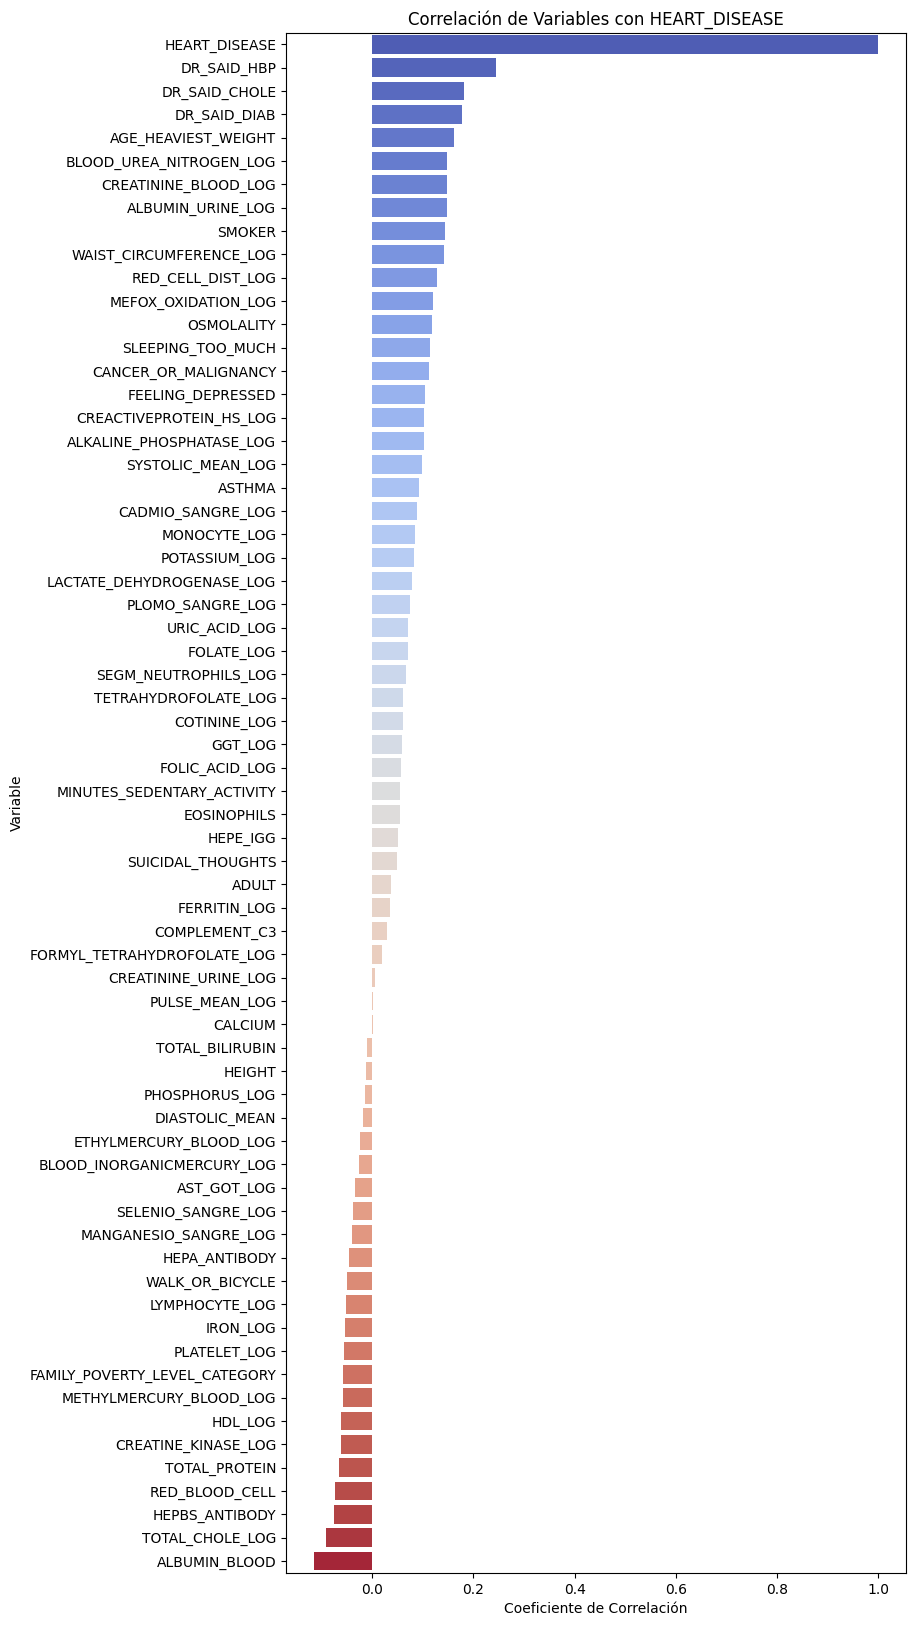

In [5]:
#matriz de correlacion del target con el resto de variables

import matplotlib.pyplot as plt
df_correlation = df.corr()
correlation_with_target = df_correlation[target].sort_values(ascending=False)
print(correlation_with_target)

plt.figure(figsize=(8, 20))
sns.barplot(x=correlation_with_target.values, y=correlation_with_target.index, palette='coolwarm')
plt.title(f'Correlación de Variables con {target}')
plt.xlabel('Coeficiente de Correlación')
plt.ylabel('Variable')
plt.show()

## LDA RAW

In [6]:
def obtener_lista_variables(dataset, target=[]):
    variables_numericas = []
    variables_booleanas = []
    variables_categoricas = []

    for i in dataset:
        if i in target:
            continue
        unique_vals = dataset[i].nunique()
        kind = dataset[i].dtype.kind

        if (kind in ["i", "f"]) and unique_vals == 2:
            variables_booleanas.append(i)
        elif (kind in ["i", "f"]) and unique_vals <= 10:
            variables_categoricas.append(i)
        elif kind in ["i", "f"]:
            variables_numericas.append(i)
        elif kind == "O":
            variables_categoricas.append(i)

    print("Variables numéricas:", variables_numericas)
    print("Variables categóricas:", variables_categoricas)
    print("Variables booleanas:", variables_booleanas)

    total_detected = len(variables_numericas) + len(variables_categoricas) + len(variables_booleanas)
    print(f"Total de variables detectadas: {total_detected}")

    return variables_numericas, variables_booleanas, variables_categoricas

In [7]:
variables_numericas, variables_booleanas, variables_categoricas = obtener_lista_variables(df, 'HEART_DISEASE')

Variables numéricas: ['HEIGHT', 'WAIST_CIRCUMFERENCE_LOG', 'SYSTOLIC_MEAN_LOG', 'DIASTOLIC_MEAN', 'PULSE_MEAN_LOG', 'ALBUMIN_URINE_LOG', 'CREATININE_URINE_LOG', 'HDL_LOG', 'TOTAL_CHOLE_LOG', 'LYMPHOCYTE_LOG', 'MONOCYTE_LOG', 'SEGM_NEUTROPHILS_LOG', 'EOSINOPHILS', 'RED_BLOOD_CELL', 'RED_CELL_DIST_LOG', 'PLATELET_LOG', 'COTININE_LOG', 'FERRITIN_LOG', 'FOLATE_LOG', 'FOLIC_ACID_LOG', 'FORMYL_TETRAHYDROFOLATE_LOG', 'TETRAHYDROFOLATE_LOG', 'MEFOX_OXIDATION_LOG', 'CREACTIVEPROTEIN_HS_LOG', 'BLOOD_INORGANICMERCURY_LOG', 'ETHYLMERCURY_BLOOD_LOG', 'METHYLMERCURY_BLOOD_LOG', 'PLOMO_SANGRE_LOG', 'CADMIO_SANGRE_LOG', 'SELENIO_SANGRE_LOG', 'MANGANESIO_SANGRE_LOG', 'ALBUMIN_BLOOD', 'ALKALINE_PHOSPHATASE_LOG', 'AST_GOT_LOG', 'BLOOD_UREA_NITROGEN_LOG', 'COMPLEMENT_C3', 'CALCIUM', 'CREATINE_KINASE_LOG', 'CREATININE_BLOOD_LOG', 'GGT_LOG', 'IRON_LOG', 'POTASSIUM_LOG', 'LACTATE_DEHYDROGENASE_LOG', 'OSMOLALITY', 'PHOSPHORUS_LOG', 'TOTAL_BILIRUBIN', 'TOTAL_PROTEIN', 'URIC_ACID_LOG', 'MINUTES_SEDENTARY_ACTIVI

Varianza explicada por cada componente:
[1.]

Centroides de las clases en el espacio LDA:
[[0.50423749 0.45028909 0.42764481 0.524388   0.48732064 0.33723973
  0.62652669 0.61377245 0.46940312 0.31275494 0.40068038 0.53606725
  0.05181928 0.42843733 0.2030126  0.73180532 0.2493982  0.519199
  0.54874933 0.2313406  0.00197444 0.28341204 0.43360944 0.38940445
  0.03980314 0.05291014 0.29797924 0.43194215 0.28273046 0.41425418
  0.49614706 0.63838911 0.40037537 0.39554458 0.49454537 0.45981611
  0.4905288  0.34254746 0.29255582 0.33895825 0.66815344 0.42860247
  0.38419209 0.44214386 0.56243624 0.12916253 0.48716434 0.59831542
  0.28473438 0.42490757]
 [0.49984196 0.49718071 0.45768302 0.52196134 0.4899828  0.3785172
  0.62793133 0.60191323 0.44547154 0.30689919 0.41694305 0.55104094
  0.05701959 0.41241749 0.23323704 0.72402367 0.30832821 0.52502333
  0.56280202 0.24488084 0.0023252  0.29974972 0.46136851 0.42800382
  0.03550117 0.04853734 0.27401316 0.44881838 0.31664909 0.40784845
  0.

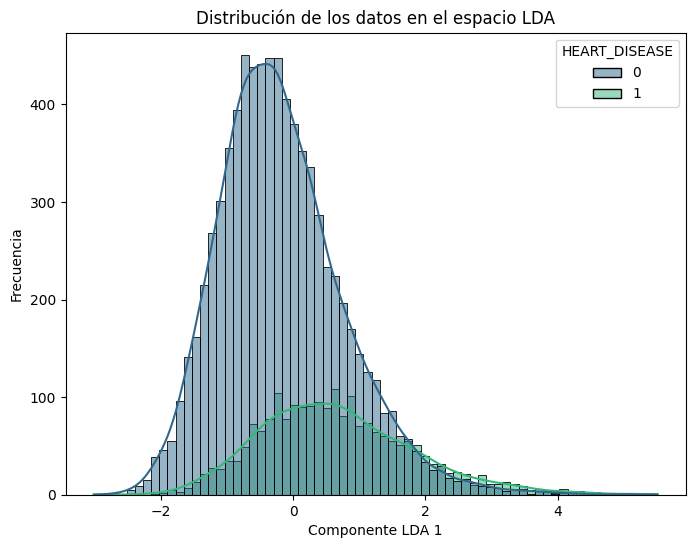

In [8]:
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split

X = df[variables_numericas]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

lda = LinearDiscriminantAnalysis(n_components=1)
lda.fit(X_train, y_train)

X_train_lda = lda.transform(X_train)
X_test_lda = lda.transform(X_test)

print("Varianza explicada por cada componente:")
print(lda.explained_variance_ratio_)

print("\nCentroides de las clases en el espacio LDA:")
print(lda.means_)

from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(X_train_lda, y_train)

accuracy = logreg.score(X_test_lda, y_test)
print(f"\nPrecisión del clasificador con los componentes LDA: {accuracy}")

if lda.n_components == 1:
    plt.figure(figsize=(8, 6))
    sns.histplot(x=X_train_lda[:, 0], hue=y_train, kde=True, palette='viridis')
    plt.title('Distribución de los datos en el espacio LDA')
    plt.xlabel('Componente LDA 1')
    plt.ylabel('Frecuencia')
    plt.show()

elif lda.n_components == 2:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=X_train_lda[:, 0], y=X_train_lda[:, 1], hue=y_train, palette='viridis', alpha=0.7)
    plt.title('Datos transformados por LDA')
    plt.xlabel('Componente LDA 1')
    plt.ylabel('Componente LDA 2')
    plt.show()


In [9]:
import pandas as pd
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split

X = df.drop(columns=['HEART_DISEASE'])
y = df['HEART_DISEASE']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

lda = LinearDiscriminantAnalysis(n_components=None)
lda.fit(X_train, y_train)

coef_df = pd.DataFrame({
    'variable': X.columns,
    'coef_abs': abs(lda.coef_[0])
}).sort_values(by='coef_abs', ascending=False)

print("Importancia de variables según coeficientes LDA:")
print(coef_df)

umbral = 0.1
variables_a_eliminar = coef_df[coef_df['coef_abs'] < umbral]['variable'].tolist()

print("\nVariables a eliminar (coef_abs < 0.1):")
print(variables_a_eliminar)

df_reducido = df.drop(columns=variables_a_eliminar)
print("\nDataFrame reducido (primeras filas):")
print(df_reducido.head())


Importancia de variables según coeficientes LDA:
                     variable  coef_abs
41       CREATININE_BLOOD_LOG  1.881576
15               PLATELET_LOG  1.820237
8             TOTAL_CHOLE_LOG  1.652472
45  LACTATE_DEHYDROGENASE_LOG  1.259228
37    BLOOD_UREA_NITROGEN_LOG  1.250743
..                        ...       ...
64                      ADULT  0.070116
25                   HEPE_IGG  0.029179
50              URIC_ACID_LOG  0.026836
32         SELENIO_SANGRE_LOG  0.023520
21       TETRAHYDROFOLATE_LOG  0.008999

[65 rows x 2 columns]

Variables a eliminar (coef_abs < 0.1):
['DIASTOLIC_MEAN', 'FOLATE_LOG', 'ETHYLMERCURY_BLOOD_LOG', 'SUICIDAL_THOUGHTS', 'HEPBS_ANTIBODY', 'ADULT', 'HEPE_IGG', 'URIC_ACID_LOG', 'SELENIO_SANGRE_LOG', 'TETRAHYDROFOLATE_LOG']

DataFrame reducido (primeras filas):
     HEIGHT  WAIST_CIRCUMFERENCE_LOG  SYSTOLIC_MEAN_LOG  PULSE_MEAN_LOG  \
0  0.750685                 0.474352           0.427834        0.546368   
1  0.571233                 0.529749  

In [10]:
#66 VARIABLES
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
)
X = df.drop(columns=['HEART_DISEASE'])
y = df['HEART_DISEASE']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)

y_pred = lda.predict(X_test)
y_prob = lda.predict_proba(X_test)[:, 1]


accuracy = accuracy_score(y_test, y_pred)

report = classification_report(y_test, y_pred, target_names=['Clase 0','Clase 1'])

auc = roc_auc_score(y_test, y_prob)

print(f"Accuracy (global): {accuracy:.3f}")             # [[1]]
print(f"AUC-ROC (global): {auc:.3f}\n")                 # [[1]]
print("Reporte de métricas por clase:\n")
print(report)


Accuracy (global): 0.799
AUC-ROC (global): 0.747

Reporte de métricas por clase:

              precision    recall  f1-score   support

     Clase 0       0.82      0.95      0.88      2094
     Clase 1       0.57      0.24      0.34       568

    accuracy                           0.80      2662
   macro avg       0.69      0.59      0.61      2662
weighted avg       0.77      0.80      0.77      2662



Accuracy (global): 0.798
AUC-ROC (global): 0.747

Reporte de métricas por clase:

              precision    recall  f1-score   support

     Clase 0       0.82      0.95      0.88      2094
     Clase 1       0.56      0.24      0.34       568

    accuracy                           0.80      2662
   macro avg       0.69      0.59      0.61      2662
weighted avg       0.77      0.80      0.76      2662



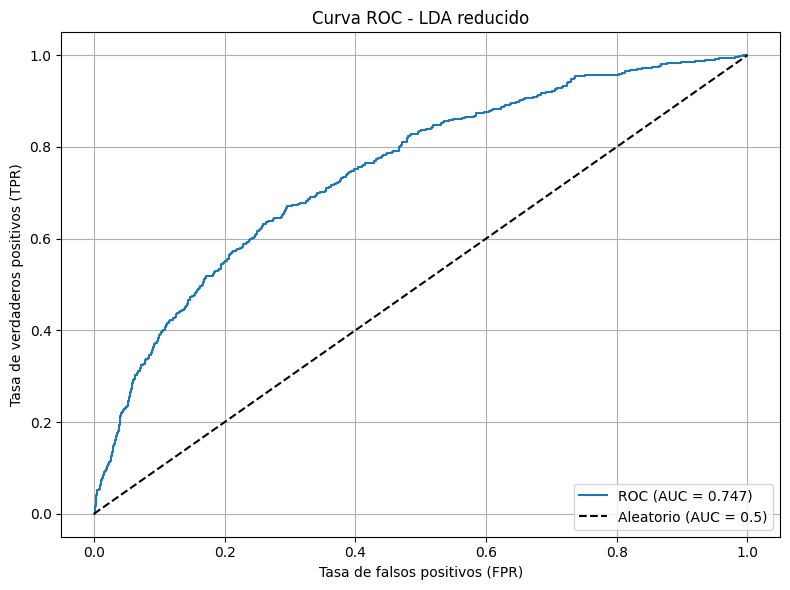

In [11]:
# DF CON VARIABLES REDUCIDAS
X_red = df_reducido.drop(columns=['HEART_DISEASE'])
y_red = df_reducido['HEART_DISEASE']

X_train, X_test, y_train, y_test = train_test_split(
    X_red, y_red, test_size=0.2, random_state=42
)

lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)

y_pred = lda.predict(X_test)
y_prob = lda.predict_proba(X_test)[:, 1]


accuracy = accuracy_score(y_test, y_pred)


report = classification_report(y_test, y_pred, target_names=['Clase 0','Clase 1'])

auc = roc_auc_score(y_test, y_prob)

print(f"Accuracy (global): {accuracy:.3f}")
print(f"AUC-ROC (global): {auc:.3f}\n")
print("Reporte de métricas por clase:\n")
print(report)

fpr, tpr, thresholds = roc_curve(y_test, y_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC (AUC = {auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Aleatorio (AUC = 0.5)')
plt.xlabel('Tasa de falsos positivos (FPR)')
plt.ylabel('Tasa de verdaderos positivos (TPR)')
plt.title('Curva ROC - LDA reducido')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


### Mejoras

#### 1 Ajustar el umbral de decisión

LDA por defecto usa un umbral de 0.5 en la probabilidad. Cambiamos el umbral y vemos como afecta al recall.

In [12]:
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score

X_train, X_test, y_train, y_test = train_test_split(
    X_red, y_red, test_size=0.2, random_state=42
)

lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)

y_prob = lda.predict_proba(X_test)[:, 1]

thresholds = np.linspace(0.0, 1.0, 101)

best_thresh = 0.5
best_f1 = 0.0
results = []

for thresh in thresholds:

    y_pred = (y_prob >= thresh).astype(int)

    prec = precision_score(y_test, y_pred, pos_label=1, zero_division=0)
    rec  = recall_score(y_test, y_pred, pos_label=1, zero_division=0)
    f1   = f1_score(y_test, y_pred, pos_label=1, zero_division=0)

    results.append((thresh, prec, rec, f1))

    if f1 > best_f1:
        best_f1 = f1
        best_thresh = thresh

print(f"Mejor umbral (máximo F1): {best_thresh:.2f} con F1 = {best_f1:.3f}")

print("\nUmbral | Precision | Recall | F1-score")
print("-" * 36)
for thresh, prec, rec, f1 in results:
    print(f"{thresh:6.2f} |   {prec:6.3f}   |  {rec:6.3f}  |  {f1:6.3f}")

Mejor umbral (máximo F1): 0.22 con F1 = 0.486

Umbral | Precision | Recall | F1-score
------------------------------------
  0.00 |    0.213   |   1.000  |   0.352
  0.01 |    0.213   |   1.000  |   0.352
  0.02 |    0.214   |   1.000  |   0.352
  0.03 |    0.215   |   0.996  |   0.354
  0.04 |    0.220   |   0.991  |   0.361
  0.05 |    0.231   |   0.982  |   0.374
  0.06 |    0.241   |   0.968  |   0.386
  0.07 |    0.257   |   0.954  |   0.405
  0.08 |    0.263   |   0.921  |   0.410
  0.09 |    0.275   |   0.896  |   0.421
  0.10 |    0.287   |   0.875  |   0.432
  0.11 |    0.300   |   0.859  |   0.444
  0.12 |    0.308   |   0.840  |   0.451
  0.13 |    0.315   |   0.813  |   0.455
  0.14 |    0.325   |   0.780  |   0.458
  0.15 |    0.333   |   0.764  |   0.463
  0.16 |    0.342   |   0.743  |   0.468
  0.17 |    0.346   |   0.717  |   0.467
  0.18 |    0.356   |   0.697  |   0.471
  0.19 |    0.363   |   0.678  |   0.473
  0.20 |    0.380   |   0.671  |   0.485
  0.21 |    0.38

Accuracy (global): 0.715
AUC-ROC (global): 0.747

Reporte de métricas por clase:

              precision    recall  f1-score   support

     Clase 0       0.88      0.74      0.80      2094
     Clase 1       0.40      0.63      0.49       568

    accuracy                           0.72      2662
   macro avg       0.64      0.68      0.64      2662
weighted avg       0.78      0.72      0.74      2662



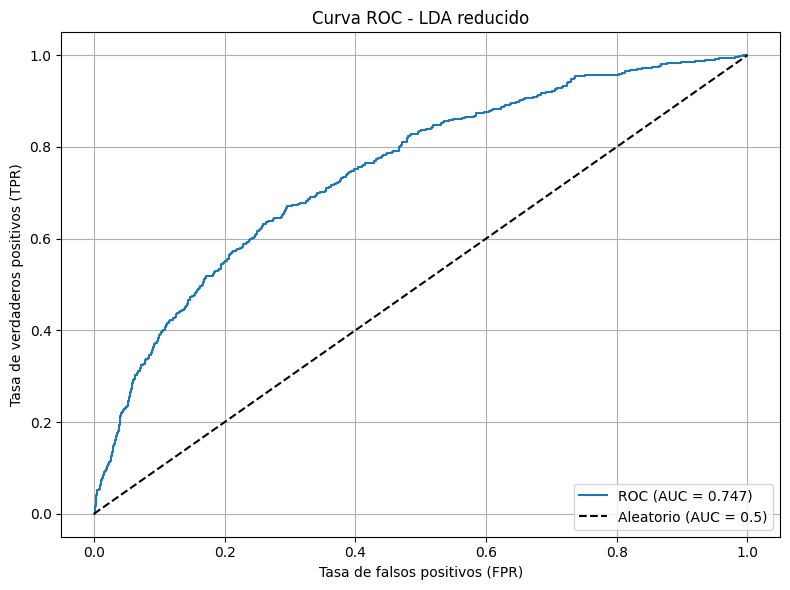

In [13]:
# Estableciendo el umbral = 0.22

X_red = df_reducido.drop(columns=['HEART_DISEASE'])
y_red = df_reducido['HEART_DISEASE']

X_train, X_test, y_train, y_test = train_test_split(
    X_red, y_red, test_size=0.2, random_state=42
)

lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)

y_pred = lda.predict(X_test)
y_prob = lda.predict_proba(X_test)[:, 1]
threshold = 0.22
y_pred = (y_prob >= threshold).astype(int)

accuracy = accuracy_score(y_test, y_pred)

report = classification_report(y_test, y_pred, target_names=['Clase 0','Clase 1'])

auc = roc_auc_score(y_test, y_prob)

print(f"Accuracy (global): {accuracy:.3f}")
print(f"AUC-ROC (global): {auc:.3f}\n")
print("Reporte de métricas por clase:\n")
print(report)

fpr, tpr, thresholds = roc_curve(y_test, y_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC (AUC = {auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Aleatorio (AUC = 0.5)')
plt.xlabel('Tasa de falsos positivos (FPR)')
plt.ylabel('Tasa de verdaderos positivos (TPR)')
plt.title('Curva ROC - LDA reducido')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

#### 2 Rebalancear las clases

In [14]:
# Subsampling

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import classification_report, roc_auc_score
import numpy as np

X = df_reducido.drop(columns=['HEART_DISEASE'])
y = df_reducido['HEART_DISEASE']

X_train_orig, X_test, y_train_orig, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

df_train_orig = X_train_orig.copy()
df_train_orig['HEART_DISEASE'] = y_train_orig

df_train_0 = df_train_orig[df_train_orig['HEART_DISEASE'] == 0]
df_train_1 = df_train_orig[df_train_orig['HEART_DISEASE'] == 1]

df_train_0_down = df_train_0.sample(n=len(df_train_1), random_state=42)

df_train_balanced = pd.concat([df_train_0_down, df_train_1])\
                     .sample(frac=1, random_state=42)\
                     .reset_index(drop=True)

X_train = df_train_balanced.drop(columns=['HEART_DISEASE'])
y_train = df_train_balanced['HEART_DISEASE']

lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)

y_prob = lda.predict_proba(X_test)[:, 1]

threshold = 0.22

y_pred_thresh = (y_prob >= threshold).astype(int)

print(classification_report(y_test, y_pred_thresh, target_names=['Clase 0','Clase 1']))
print(f"AUC-ROC: {roc_auc_score(y_test, y_prob):.3f}")

              precision    recall  f1-score   support

     Clase 0       0.94      0.19      0.32      2089
     Clase 1       0.24      0.95      0.39       573

    accuracy                           0.36      2662
   macro avg       0.59      0.57      0.36      2662
weighted avg       0.79      0.36      0.34      2662

AUC-ROC: 0.755


In [15]:
#Rebalanceado + Umbral 0.22

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import classification_report, roc_auc_score

X = df_reducido.drop(columns=['HEART_DISEASE'])
y = df_reducido['HEART_DISEASE']

X_train_orig, X_test, y_train_orig, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

df_train_orig = X_train_orig.copy()
df_train_orig['HEART_DISEASE'] = y_train_orig

df_train_0 = df_train_orig[df_train_orig['HEART_DISEASE'] == 0]
df_train_1 = df_train_orig[df_train_orig['HEART_DISEASE'] == 1]

df_train_0_down = df_train_0.sample(n=len(df_train_1), random_state=42)

df_train_balanced = pd.concat([df_train_0_down, df_train_1])\
                     .sample(frac=1, random_state=42)\
                     .reset_index(drop=True)

X_train = df_train_balanced.drop(columns=['HEART_DISEASE'])
y_train = df_train_balanced['HEART_DISEASE']

lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)


y_prob = lda.predict_proba(X_test)[:, 1]
threshold = 0.22

y_pred_thresh = (y_prob >= threshold).astype(int)
print(classification_report(y_test, y_pred_thresh, target_names=['Clase 0','Clase 1']))
print(f"AUC-ROC: {roc_auc_score(y_test, y_prob):.3f}")

              precision    recall  f1-score   support

     Clase 0       0.94      0.19      0.32      2089
     Clase 1       0.24      0.95      0.39       573

    accuracy                           0.36      2662
   macro avg       0.59      0.57      0.36      2662
weighted avg       0.79      0.36      0.34      2662

AUC-ROC: 0.755


#### 3 Asignar pesos a las clases



Al entrenar LDA (u otro clasificador), definimos class_weight={'0':1, '1':X} aumentando el peso de la clase 1. Con un mayor peso, el algoritmo penalizará más los falsos negativos en clase 1.

In [16]:
#Asignar probabilidad 0.5-0.5 + umbral 0.22
import pandas as pd
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score


X_train, X_test, y_train, y_test = train_test_split(
    X_red, y_red, test_size=0.2, stratify=y_red, random_state=42
)

priors = [0.5, 0.5]

lda = LinearDiscriminantAnalysis(priors=priors)
lda.fit(X_train, y_train)

y_prob = lda.predict_proba(X_test)[:, 1]
umbral = 0.22
y_pred_umbral = (y_prob >= umbral).astype(int)

accuracy = accuracy_score(y_test, y_pred_umbral)
report = classification_report(y_test, y_pred_umbral, target_names=['Clase 0', 'Clase 1'])
auc = roc_auc_score(y_test, y_prob)

print(f"Accuracy (global): {accuracy:.3f}")
print(f"AUC-ROC (global): {auc:.3f}\n")
print("Reporte de métricas por clase:\n")
print(report)


Accuracy (global): 0.376
AUC-ROC (global): 0.755

Reporte de métricas por clase:

              precision    recall  f1-score   support

     Clase 0       0.93      0.22      0.36      2089
     Clase 1       0.25      0.94      0.39       573

    accuracy                           0.38      2662
   macro avg       0.59      0.58      0.38      2662
weighted avg       0.78      0.38      0.37      2662



In [17]:
#Asignar probabilidad 0.7-0.3 + umbral 0.22

import pandas as pd
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

X_train, X_test, y_train, y_test = train_test_split(
    X_red, y_red, test_size=0.2, stratify=y_red, random_state=42
)

priors = [0.7, 0.3]

lda = LinearDiscriminantAnalysis(priors=priors)
lda.fit(X_train, y_train)

y_prob = lda.predict_proba(X_test)[:, 1]
umbral = 0.22
y_pred_umbral = (y_prob >= umbral).astype(int)

accuracy = accuracy_score(y_test, y_pred_umbral)
report = classification_report(y_test, y_pred_umbral, target_names=['Clase 0', 'Clase 1'])
auc = roc_auc_score(y_test, y_prob)

print(f"Accuracy (global): {accuracy:.3f}")
print(f"AUC-ROC (global): {auc:.3f}\n")
print("Reporte de métricas por clase:\n")
print(report)


Accuracy (global): 0.629
AUC-ROC (global): 0.755

Reporte de métricas por clase:

              precision    recall  f1-score   support

     Clase 0       0.91      0.59      0.71      2089
     Clase 1       0.34      0.79      0.48       573

    accuracy                           0.63      2662
   macro avg       0.63      0.69      0.59      2662
weighted avg       0.79      0.63      0.66      2662



In [18]:
#Asignar probabilidad 0.6-0.4 + umbral 0.22

import pandas as pd
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

X_train, X_test, y_train, y_test = train_test_split(
    X_red, y_red, test_size=0.2, stratify=y_red, random_state=42
)

priors = [0.6, 0.4]

lda = LinearDiscriminantAnalysis(priors=priors)
lda.fit(X_train, y_train)

y_prob = lda.predict_proba(X_test)[:, 1]
umbral = 0.22
y_pred_umbral = (y_prob >= umbral).astype(int)

accuracy = accuracy_score(y_test, y_pred_umbral)
report = classification_report(y_test, y_pred_umbral, target_names=['Clase 0', 'Clase 1'])
auc = roc_auc_score(y_test, y_prob)

print(f"Accuracy (global): {accuracy:.3f}")
print(f"AUC-ROC (global): {auc:.3f}\n")
print("Reporte de métricas por clase:\n")
print(report)


Accuracy (global): 0.508
AUC-ROC (global): 0.755

Reporte de métricas por clase:

              precision    recall  f1-score   support

     Clase 0       0.92      0.41      0.56      2089
     Clase 1       0.29      0.88      0.43       573

    accuracy                           0.51      2662
   macro avg       0.61      0.64      0.50      2662
weighted avg       0.79      0.51      0.54      2662



In [19]:
#Asignar probabilidad 0.8-0.2 + umbral 0.22

import pandas as pd
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

X_train, X_test, y_train, y_test = train_test_split(
    X_red, y_red, test_size=0.2, stratify=y_red, random_state=42
)

priors = [0.8, 0.2]

lda = LinearDiscriminantAnalysis(priors=priors)
lda.fit(X_train, y_train)

y_prob = lda.predict_proba(X_test)[:, 1]
umbral = 0.22
y_pred_umbral = (y_prob >= umbral).astype(int)

accuracy = accuracy_score(y_test, y_pred_umbral)
report = classification_report(y_test, y_pred_umbral, target_names=['Clase 0', 'Clase 1'])
auc = roc_auc_score(y_test, y_prob)

print(f"Accuracy (global): {accuracy:.3f}")
print(f"AUC-ROC (global): {auc:.3f}\n")
print("Reporte de métricas por clase:\n")
print(report)

Accuracy (global): 0.729
AUC-ROC (global): 0.755

Reporte de métricas por clase:

              precision    recall  f1-score   support

     Clase 0       0.88      0.75      0.81      2089
     Clase 1       0.42      0.64      0.50       573

    accuracy                           0.73      2662
   macro avg       0.65      0.70      0.66      2662
weighted avg       0.78      0.73      0.75      2662



In [20]:
# Asignar probabilidad 0.6/0.4 + umbral 0.22 + subsampling
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score

df = df_reducido.copy()

X = df.drop(columns=['HEART_DISEASE'])
y = df['HEART_DISEASE']
X_train_orig, X_test, y_train_orig, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

df_train_orig = X_train_orig.copy()
df_train_orig['HEART_DISEASE'] = y_train_orig

df_train_0 = df_train_orig[df_train_orig['HEART_DISEASE'] == 0]
df_train_1 = df_train_orig[df_train_orig['HEART_DISEASE'] == 1]

df_train_0_down = df_train_0.sample(n=len(df_train_1), random_state=42)
df_train_balanced = pd.concat([df_train_0_down, df_train_1])\
                     .sample(frac=1, random_state=42)\
                     .reset_index(drop=True)

X_train = df_train_balanced.drop(columns=['HEART_DISEASE'])
y_train = df_train_balanced['HEART_DISEASE']

priors = [0.6, 0.4]
lda = LinearDiscriminantAnalysis(priors=priors)
lda.fit(X_train, y_train)

y_prob = lda.predict_proba(X_test)[:, 1]

threshold = 0.22
y_pred = (y_prob >= threshold).astype(int)

accuracy = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)
report = classification_report(y_test, y_pred, target_names=['Clase 0','Clase 1'])

print(f"Accuracy (global): {accuracy:.3f}")
print(f"AUC-ROC (global): {auc:.3f}\n")
print("Reporte de métricas por clase:\n", report)



Accuracy (global): 0.483
AUC-ROC (global): 0.755

Reporte de métricas por clase:
               precision    recall  f1-score   support

     Clase 0       0.93      0.37      0.53      2089
     Clase 1       0.28      0.89      0.43       573

    accuracy                           0.48      2662
   macro avg       0.60      0.63      0.48      2662
weighted avg       0.79      0.48      0.51      2662



## LDA MEJORADO

In [21]:
LDA_met = pd.read_csv('/content/drive/MyDrive/NUCLIO/M7 - TFM/EXCEL_FILES/EXCEL_FILES_FILTERED/LDA_PP.csv')
LDA_met

Unnamed: 0    LDA  LDA + U=0.22  LDA + Reb + U=0.22  \
0    Accuracy global  0.799         0.715               0.360   
1     AUC-ROC global  0.747         0.747               0.755   
2  Clase 0 Precision  0.820         0.880               0.940   
3     Clase 0 Recall  0.950         0.740               0.190   
4   Clase 0 F1-score  0.880         0.800               0.320   
5  Clase 1 Precision  0.570         0.400               0.240   
6     Clase 1 Recall  0.240         0.630               0.950   
7   Clase 1 F1-score  0.340         0.490               0.390   

   LDA P. 0.6/0.4 + U=0.22  LDA P. 0.8/0.2 + U=0.22  
0                    0.508                    0.729  
1                    0.755                    0.755  
2                    0.920                    0.880  
3                    0.410                    0.750  
4                    0.560                    0.810  
5                    0.290                    0.420  
6                    0.880                    0.640  
7                    0.430                    0.500

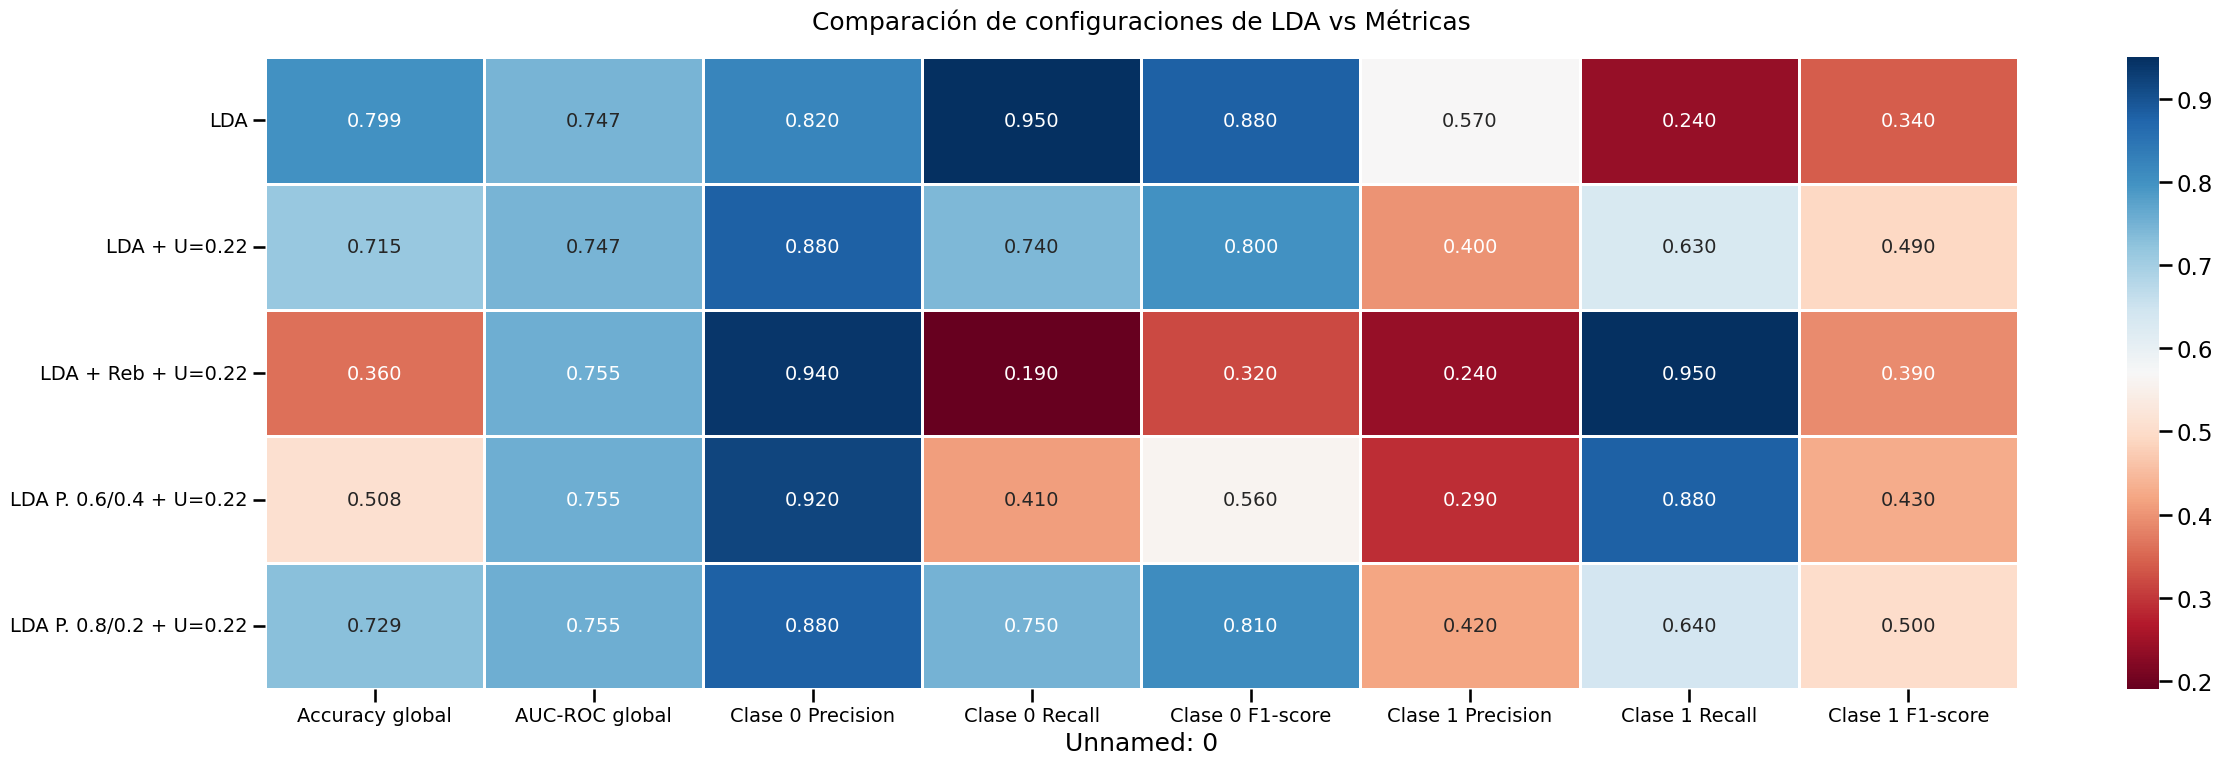

In [22]:
# Establecer la primera columna ('Unnamed: 0') como índice.
LDA_met = LDA_met.set_index('Unnamed: 0')


LDA_met = LDA_met.astype(float)
LDA_met_T = LDA_met.T


sns.set_context("talk")
plt.figure(figsize=(25, 8))
sns.heatmap(
    LDA_met_T,
    annot=True,
    fmt=".3f",
    cmap="RdBu",
    cbar_kws={},
    annot_kws={"size": 14},
    linewidths=1,
    linecolor="white"
)

plt.xticks(rotation=0, ha="center", fontsize=14)
plt.yticks(rotation=0, fontsize=14)

plt.title("Comparación de configuraciones de LDA vs Métricas", fontsize=18, pad=20)

plt.tight_layout()
plt.show()

NOS QUEDAMOS CON LDA + PROBABILIDAD 0.6/0.4 + UMBRAL 0.22

In [23]:
#Asignar probabilidad 0.6-0.4 + umbral 0.22

import pandas as pd
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

X_train, X_test, y_train, y_test = train_test_split(
    X_red, y_red, test_size=0.2, stratify=y_red, random_state=42
)

priors = [0.6, 0.4]

lda = LinearDiscriminantAnalysis(priors=priors)
lda.fit(X_train, y_train)

y_prob = lda.predict_proba(X_test)[:, 1]
umbral = 0.22
y_pred_umbral = (y_prob >= umbral).astype(int)

accuracy = accuracy_score(y_test, y_pred_umbral)
report = classification_report(y_test, y_pred_umbral, target_names=['Clase 0', 'Clase 1'])
auc = roc_auc_score(y_test, y_prob)

print(f"Accuracy (global): {accuracy:.3f}")
print(f"AUC-ROC (global): {auc:.3f}\n")
print("Reporte de métricas por clase:\n")
print(report)

Accuracy (global): 0.508
AUC-ROC (global): 0.755

Reporte de métricas por clase:

              precision    recall  f1-score   support

     Clase 0       0.92      0.41      0.56      2089
     Clase 1       0.29      0.88      0.43       573

    accuracy                           0.51      2662
   macro avg       0.61      0.64      0.50      2662
weighted avg       0.79      0.51      0.54      2662



In [25]:
cm = confusion_matrix(y_test, y_pred_umbral)
cm_perc = cm.astype('float') / cm.sum(axis=1)[:, None] * 100
cell_labels = np.array([['TN', 'FP'],
                        ['FN', 'TP']])


annot = np.empty_like(cell_labels, dtype=object)
for i in range(2):
    for j in range(2):
        annot[i, j] = f"{cell_labels[i,j]}\n{cm[i,j]} ({cm_perc[i,j]:.1f}%)"


import seaborn as sns
plt.figure(figsize=(6,6))
sns.heatmap(
    cm,
    annot=annot,
    fmt='',
    cmap='Blues',
    cbar=False,
    linewidths=2,
    linecolor='white',
    annot_kws={"size":14}
)
#Ajuste etqietas
plt.xticks([0.5,1.5], ['0','1'], fontsize=12)
plt.yticks([0.5,1.5], ['0','1'], fontsize=12)
plt.xlabel('Predicción', fontsize=14)
plt.ylabel('Valor Real', fontsize=14)
plt.title('Matriz de Confusión', fontsize=16, pad=12)

plt.tight_layout()
plt.show()


NameError: name 'confusion_matrix' is not defined

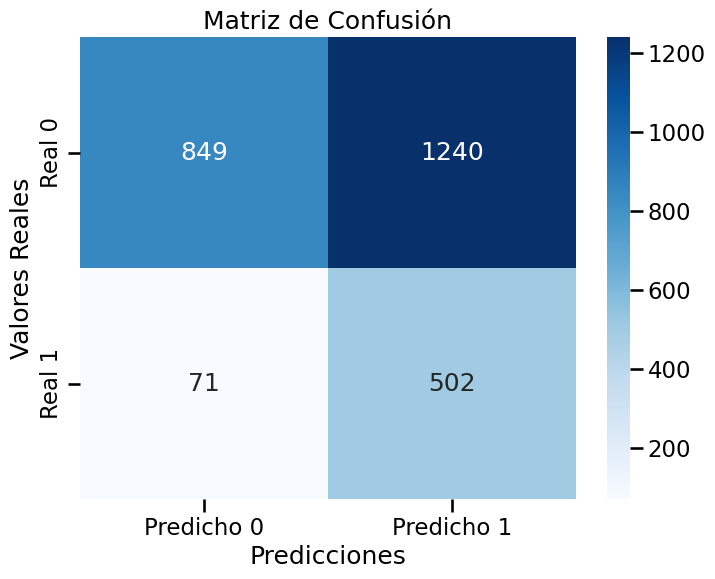

In [26]:
# Matriz de confusion

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred_umbral)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicho 0', 'Predicho 1'], yticklabels=['Real 0', 'Real 1'])
plt.xlabel('Predicciones')
plt.ylabel('Valores Reales')
plt.title('Matriz de Confusión')
plt.show()


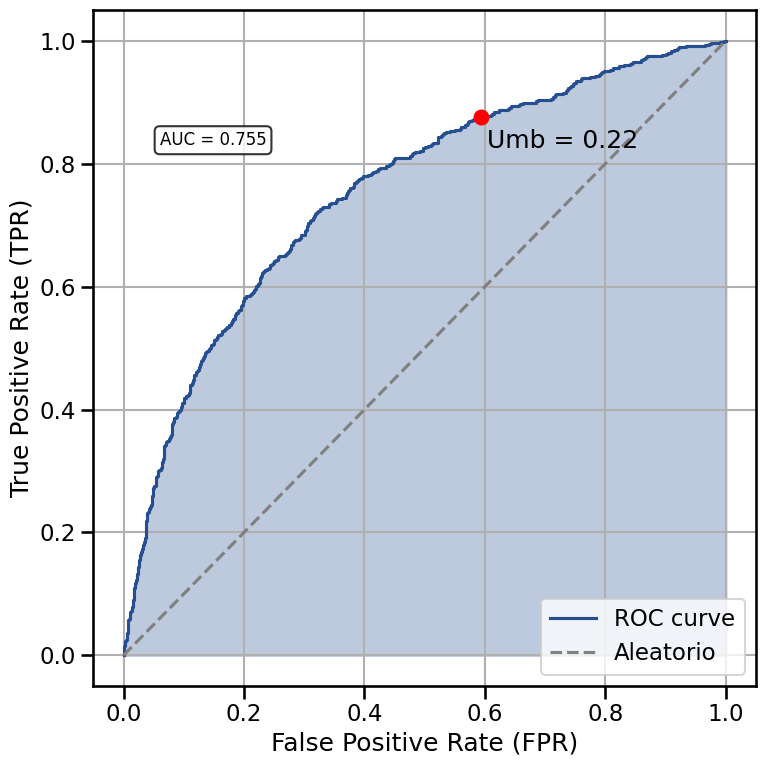

In [27]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
auc = roc_auc_score(y_test, y_prob)
idx = np.argmin(np.abs(thresholds - umbral))

plt.figure(figsize=(8,8))

# Sombreamos el AUC
plt.fill_between(fpr, tpr, alpha=0.3, color='#264F91')

# Dibujamos la curva ROC
plt.plot(fpr, tpr, color='#264F91', label=f'ROC curve')

# Diagonal aleatoria
plt.plot([0,1], [0,1], '--', color='gray', label='Aleatorio')

# Marcamos el umbral
plt.scatter(fpr[idx], tpr[idx], color='red', s=100, zorder=5)
plt.annotate(
    f'Umb = {umbral:.2f}',
    xy=(fpr[idx], tpr[idx]),
    xytext=(fpr[idx]+0.01, tpr[idx]-0.05)
)

# Anotamos el valor de AUC como texto
plt.text(
    0.1, 0.8,
    f'AUC = {auc:.3f}',
    transform=plt.gca().transAxes,
    fontsize=12,
    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8)
)

plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


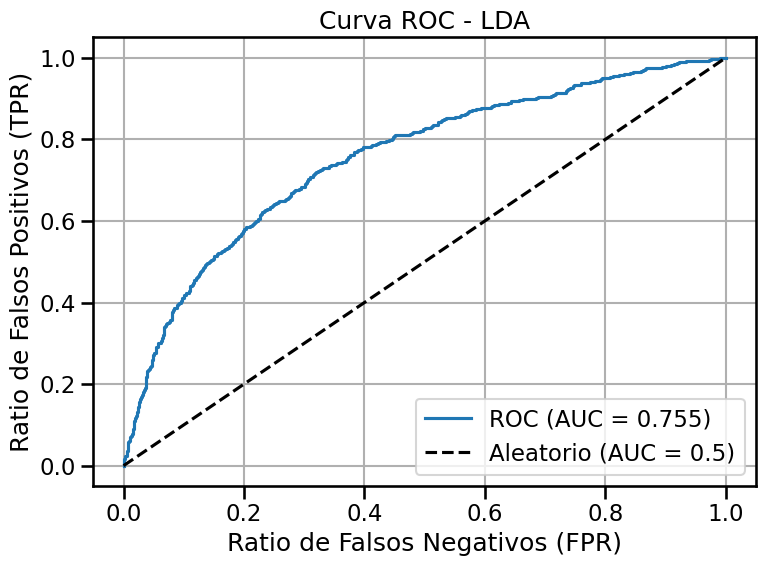

In [28]:
# Curva AUC

import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test, y_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC (AUC = {auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Aleatorio (AUC = 0.5)')
plt.xlabel('Ratio de Falsos Negativos (FPR)')
plt.ylabel('Ratio de Falsos Positivos (TPR)')
plt.title('Curva ROC - LDA')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


In [29]:
coef = lda.coef_[0]
intercept = lda.intercept_[0]

feature_names = X_train.columns.tolist()


ecuacion = f"LD(x) = {intercept:.3f}"
for nombre, wj in zip(feature_names, coef):
    signo = "+" if wj >= 0 else "-"
    ecuacion += f" {signo} {abs(wj):.3f} \* {nombre}"
print(ecuacion)


LD(x) = -1.410 - 0.493 \* HEIGHT + 0.738 \* WAIST_CIRCUMFERENCE_LOG - 0.339 \* SYSTOLIC_MEAN_LOG + 0.104 \* PULSE_MEAN_LOG + 1.394 \* ALBUMIN_URINE_LOG - 0.642 \* CREATININE_URINE_LOG - 0.286 \* HDL_LOG - 1.837 \* TOTAL_CHOLE_LOG - 0.962 \* LYMPHOCYTE_LOG + 0.587 \* MONOCYTE_LOG + 0.065 \* SEGM_NEUTROPHILS_LOG + 0.100 \* EOSINOPHILS - 0.710 \* RED_BLOOD_CELL + 1.011 \* RED_CELL_DIST_LOG - 1.415 \* PLATELET_LOG + 0.072 \* COTININE_LOG - 0.624 \* FERRITIN_LOG + 0.185 \* FOLIC_ACID_LOG + 1.840 \* FORMYL_TETRAHYDROFOLATE_LOG + 0.826 \* MEFOX_OXIDATION_LOG - 0.215 \* HEPA_ANTIBODY + 0.135 \* CREACTIVEPROTEIN_HS_LOG - 0.612 \* BLOOD_INORGANICMERCURY_LOG - 0.455 \* METHYLMERCURY_BLOOD_LOG + 0.446 \* PLOMO_SANGRE_LOG + 0.295 \* CADMIO_SANGRE_LOG - 0.098 \* MANGANESIO_SANGRE_LOG - 0.034 \* ALBUMIN_BLOOD + 0.798 \* ALKALINE_PHOSPHATASE_LOG - 0.737 \* AST_GOT_LOG + 1.145 \* BLOOD_UREA_NITROGEN_LOG + 0.835 \* COMPLEMENT_C3 + 0.131 \* CALCIUM - 1.255 \* CREATINE_KINASE_LOG + 2.146 \* CREATININE_BLO

### Separacion de las clases

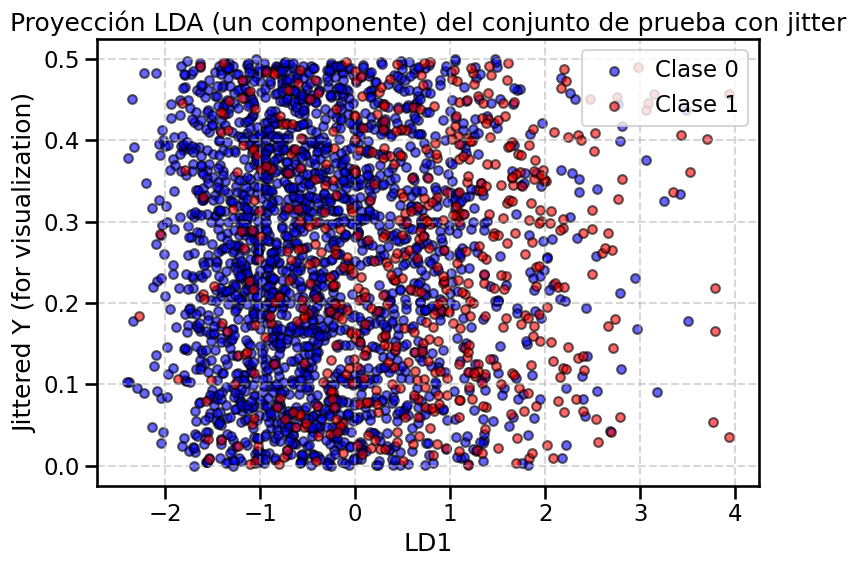

In [30]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_vis = X_red
y_vis = y_red

X_train_vis, X_test_vis, y_train_vis, y_test_vis = train_test_split(
    X_vis, y_vis, test_size=0.2, stratify=y_vis, random_state=42
)

lda_vis = LinearDiscriminantAnalysis(n_components=1, priors=priors)
lda_vis.fit(X_train_vis, y_train_vis)

X_test_lda_vis = lda_vis.transform(X_test_vis)

plt.figure(figsize=(8, 6))
for clase, color, etiqueta in [(0, 'blue', 'Clase 0'), (1, 'red', 'Clase 1')]:

    idx = (y_test_vis == clase)

    if lda_vis.n_components == 1:
        plt.scatter(
            X_test_lda_vis[idx, 0],
            np.random.rand(np.sum(idx)) * 0.5,
            c=color, label=etiqueta, alpha=0.6, edgecolors='k', s=40
        )
        plt.ylabel('Jittered Y (for visualization)')
    elif lda_vis.n_components == 2:
         plt.scatter(
            X_test_lda_vis[idx, 0],
            X_test_lda_vis[idx, 1],
            c=color, label=etiqueta, alpha=0.6, edgecolors='k', s=40
        )
         plt.ylabel('LD2')


plt.xlabel('LD1')
plt.title('Proyección LDA (un componente) del conjunto de prueba con jitter')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

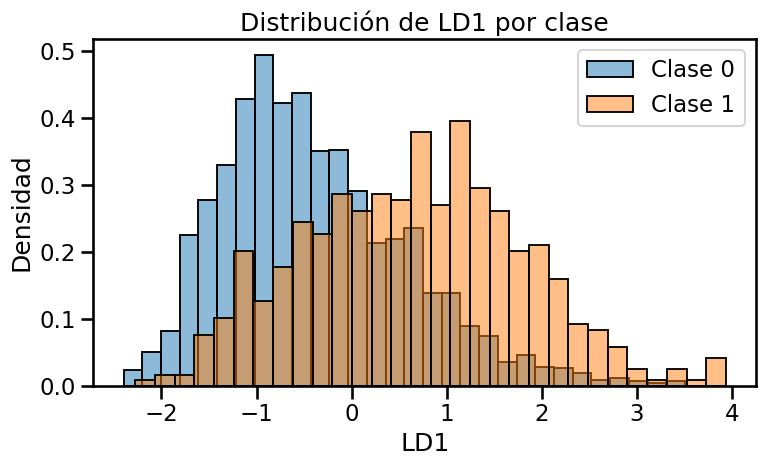

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

lda_vals = lda.transform(X_test).ravel()

plt.figure(figsize=(8, 5))
sns.histplot(lda_vals[y_test==0], color="C0", label="Clase 0",
             stat="density", bins=30, alpha=0.5)
sns.histplot(lda_vals[y_test==1], color="C1", label="Clase 1",
             stat="density", bins=30, alpha=0.5)
plt.xlabel("LD1")
plt.ylabel("Densidad")
plt.title("Distribución de LD1 por clase")
plt.legend()
plt.tight_layout()
plt.show()


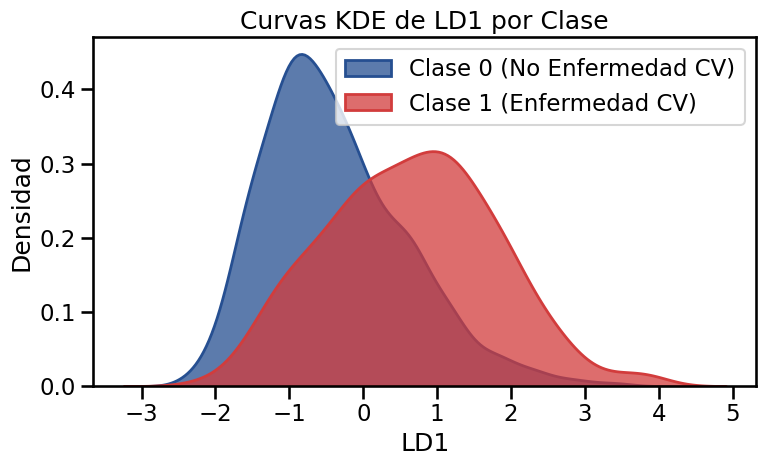

In [32]:
plt.figure(figsize=(8, 5))
sns.kdeplot(lda_vals[y_test==0], color="#264F91", label="Clase 0 (No Enfermedad CV)", fill=True, alpha=0.75, linewidth=2)
sns.kdeplot(lda_vals[y_test==1], color="#D23C3C", label="Clase 1 (Enfermedad CV)", fill=True, alpha=0.75, linewidth=2)
plt.xlabel("LD1")
plt.ylabel("Densidad")
plt.title("Curvas KDE de LD1 por Clase")
plt.legend()
plt.tight_layout()
plt.show()


<ipython-input-33-a945c8dbe25e>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Clase", y="LD1", data=df_vis, palette=["C0","C1"])


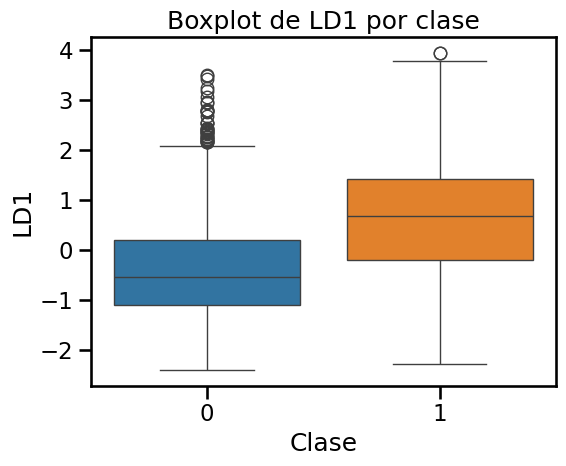

In [33]:
import pandas as pd

df_vis = pd.DataFrame({
    "LD1": lda_vals,
    "Clase": y_test.values
})

plt.figure(figsize=(6, 5))
sns.boxplot(x="Clase", y="LD1", data=df_vis, palette=["C0","C1"])
plt.xlabel("Clase")
plt.ylabel("LD1")
plt.title("Boxplot de LD1 por clase")
plt.tight_layout()
plt.show()


## VARIABLES RELEVANTES

In [34]:
df_reducido.columns

Index(['HEIGHT', 'WAIST_CIRCUMFERENCE_LOG', 'SYSTOLIC_MEAN_LOG',
       'PULSE_MEAN_LOG', 'ALBUMIN_URINE_LOG', 'CREATININE_URINE_LOG',
       'HDL_LOG', 'TOTAL_CHOLE_LOG', 'LYMPHOCYTE_LOG', 'MONOCYTE_LOG',
       'SEGM_NEUTROPHILS_LOG', 'EOSINOPHILS', 'RED_BLOOD_CELL',
       'RED_CELL_DIST_LOG', 'PLATELET_LOG', 'COTININE_LOG', 'FERRITIN_LOG',
       'FOLIC_ACID_LOG', 'FORMYL_TETRAHYDROFOLATE_LOG', 'MEFOX_OXIDATION_LOG',
       'HEPA_ANTIBODY', 'CREACTIVEPROTEIN_HS_LOG',
       'BLOOD_INORGANICMERCURY_LOG', 'METHYLMERCURY_BLOOD_LOG',
       'PLOMO_SANGRE_LOG', 'CADMIO_SANGRE_LOG', 'MANGANESIO_SANGRE_LOG',
       'ALBUMIN_BLOOD', 'ALKALINE_PHOSPHATASE_LOG', 'AST_GOT_LOG',
       'BLOOD_UREA_NITROGEN_LOG', 'COMPLEMENT_C3', 'CALCIUM',
       'CREATINE_KINASE_LOG', 'CREATININE_BLOOD_LOG', 'GGT_LOG', 'IRON_LOG',
       'POTASSIUM_LOG', 'LACTATE_DEHYDROGENASE_LOG', 'OSMOLALITY',
       'PHOSPHORUS_LOG', 'TOTAL_BILIRUBIN', 'TOTAL_PROTEIN', 'DR_SAID_HBP',
       'DR_SAID_CHOLE', 'DR_SAID_DIAB'

Columnas en df: ['HEIGHT', 'WAIST_CIRCUMFERENCE_LOG', 'SYSTOLIC_MEAN_LOG', 'PULSE_MEAN_LOG', 'ALBUMIN_URINE_LOG', 'CREATININE_URINE_LOG', 'HDL_LOG', 'TOTAL_CHOLE_LOG', 'LYMPHOCYTE_LOG', 'MONOCYTE_LOG', 'SEGM_NEUTROPHILS_LOG', 'EOSINOPHILS', 'RED_BLOOD_CELL', 'RED_CELL_DIST_LOG', 'PLATELET_LOG', 'COTININE_LOG', 'FERRITIN_LOG', 'FOLIC_ACID_LOG', 'FORMYL_TETRAHYDROFOLATE_LOG', 'MEFOX_OXIDATION_LOG', 'HEPA_ANTIBODY', 'CREACTIVEPROTEIN_HS_LOG', 'BLOOD_INORGANICMERCURY_LOG', 'METHYLMERCURY_BLOOD_LOG', 'PLOMO_SANGRE_LOG', 'CADMIO_SANGRE_LOG', 'MANGANESIO_SANGRE_LOG', 'ALBUMIN_BLOOD', 'ALKALINE_PHOSPHATASE_LOG', 'AST_GOT_LOG', 'BLOOD_UREA_NITROGEN_LOG', 'COMPLEMENT_C3', 'CALCIUM', 'CREATINE_KINASE_LOG', 'CREATININE_BLOOD_LOG', 'GGT_LOG', 'IRON_LOG', 'POTASSIUM_LOG', 'LACTATE_DEHYDROGENASE_LOG', 'OSMOLALITY', 'PHOSPHORUS_LOG', 'TOTAL_BILIRUBIN', 'TOTAL_PROTEIN', 'DR_SAID_HBP', 'DR_SAID_CHOLE', 'DR_SAID_DIAB', 'FAMILY_POVERTY_LEVEL_CATEGORY', 'ASTHMA', 'CANCER_OR_MALIGNANCY', 'FEELING_DEPRESSED'

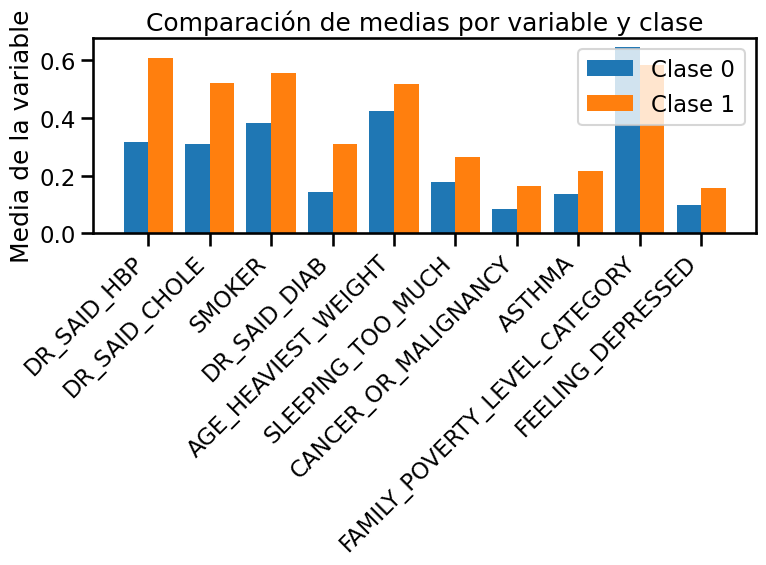

In [35]:
import pandas as pd
import matplotlib.pyplot as plt

print("Columnas en df:", df.columns.tolist())

medias_por_clase = df_reducido.groupby('HEART_DISEASE').mean()

medias_por_clase = medias_por_clase.T

diff = (medias_por_clase[1] - medias_por_clase[0]).abs()
vars_a_mostrar = diff.sort_values(ascending=False).index[:10]

fig, ax = plt.subplots(figsize=(8, 6))
x = range(len(vars_a_mostrar))

ax.bar([i - 0.2 for i in x],
       medias_por_clase.loc[vars_a_mostrar, 0],
       width=0.4, label='Clase 0')
ax.bar([i + 0.2 for i in x],
       medias_por_clase.loc[vars_a_mostrar, 1],
       width=0.4, label='Clase 1')

ax.set_xticks(x)
ax.set_xticklabels(vars_a_mostrar, rotation=45, ha='right')
ax.set_ylabel('Media de la variable')
ax.set_title('Comparación de medias por variable y clase')
ax.legend()
plt.tight_layout()
plt.show()


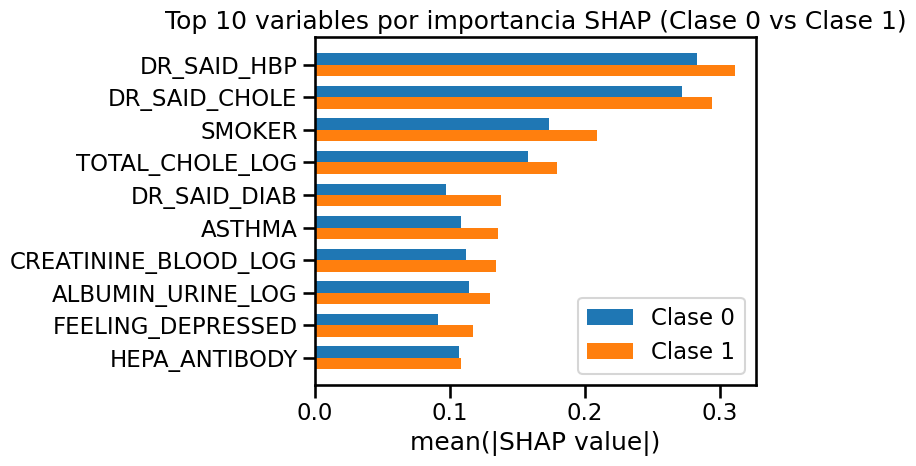

In [36]:
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

background_data = shap.sample(X_train, 100, random_state=42)

explainer = shap.Explainer(lda, background_data)

shap_values_test = explainer(X_test)

if isinstance(shap_values_test, list):
    shap_values_test_class1 = shap_values_test[1].values
else:
    shap_values_test_class1 = shap_values_test.values

df_shap = pd.DataFrame(shap_values_test_class1, columns=X_test.columns, index=X_test.index)

shap_c0 = df_shap.loc[y_test == 0].abs().mean(axis=0)
shap_c1 = df_shap.loc[y_test == 1].abs().mean(axis=0)

df_mean_shap = pd.DataFrame({
    'Clase 0': shap_c0,
    'Clase 1': shap_c1
})

top10_vars = df_mean_shap.max(axis=1).sort_values(ascending=False).head(10).index.tolist()
df_top10 = df_mean_shap.loc[top10_vars]

plt.figure(figsize=(8, 5))
x = np.arange(len(top10_vars))
width = 0.35

plt.barh(x - width/2, df_top10['Clase 0'], height=width, label='Clase 0', color='C0')
plt.barh(x + width/2, df_top10['Clase 1'], height=width, label='Clase 1', color='C1')

plt.yticks(x, top10_vars)
plt.xlabel('mean(|SHAP value|)')
plt.title('Top 10 variables por importancia SHAP (Clase 0 vs Clase 1)')
plt.legend()
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


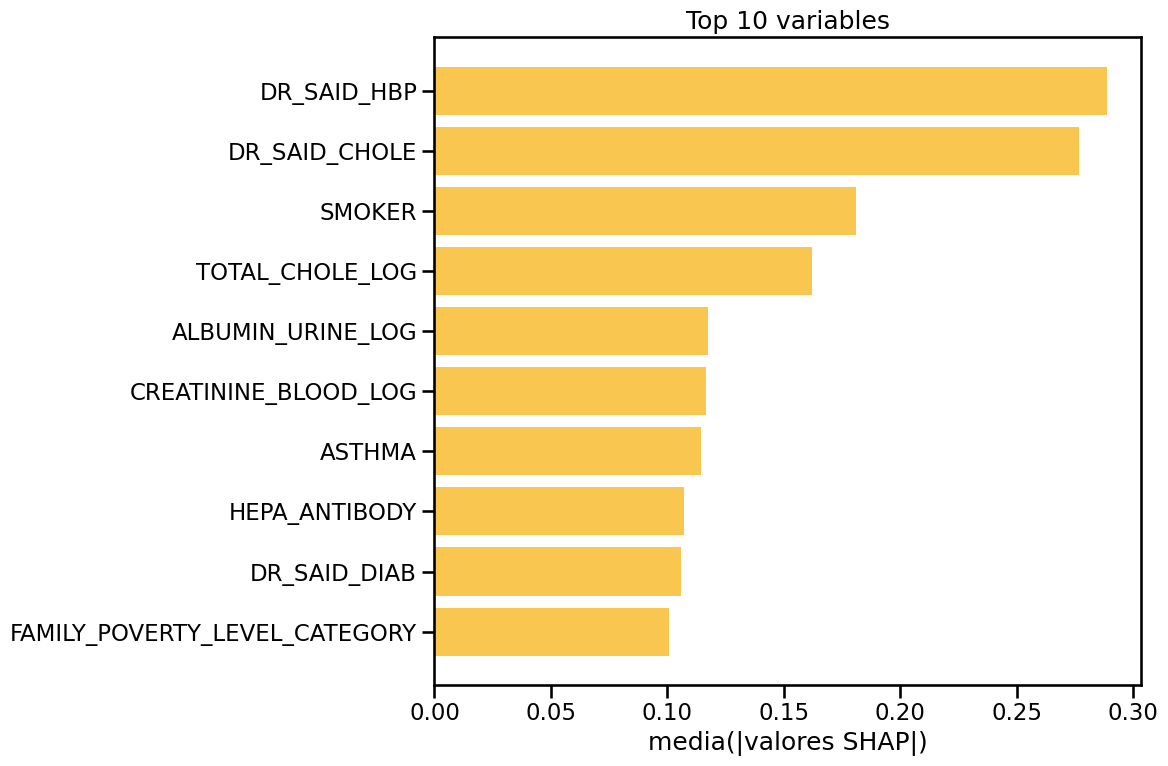

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

mean_abs_shap = np.mean(np.abs(shap_values_test.values), axis=0)
feature_names = X_test.columns.tolist()

df_imps = pd.DataFrame({
    "feature": feature_names,
    "mean_abs_shap": mean_abs_shap
})
df_top10 = df_imps.sort_values("mean_abs_shap", ascending=False).head(10)

plt.figure(figsize=(12, 8))
plt.barh(
    df_top10["feature"][::-1],
    df_top10["mean_abs_shap"][::-1],
    color="#F9C74F"
)
plt.xlabel("media(|valores SHAP|)")
plt.title("Top 10 variables")
plt.tight_layout()
plt.show()


SHAP Summary Plot for Class 1:


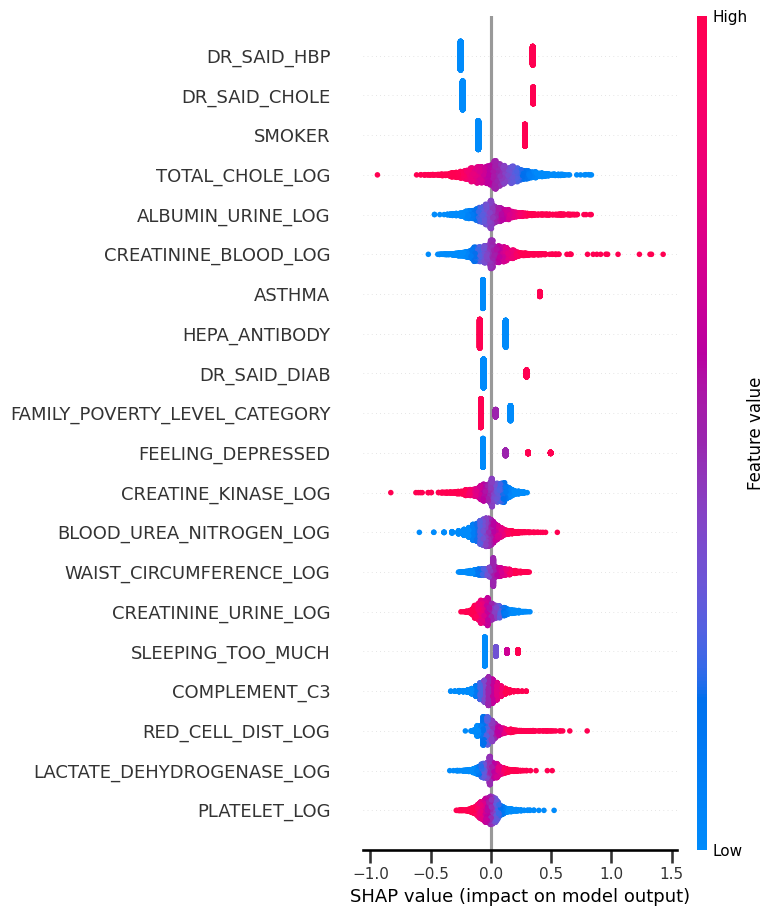

In [38]:
import shap
import numpy as np
import matplotlib.pyplot as plt

shap_values_test = explainer(X_test)

if isinstance(shap_values_test, list):
    shap_values_class1 = shap_values_test[1]
else:

    shap_values_class1 = shap_values_test

print("SHAP Summary Plot for Class 1:")
shap.summary_plot(shap_values_class1, X_test, show=True)

/usr/local/lib/python3.11/dist-packages/shap/explainers/_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


Top 10 variables por SHAP (media absoluta) en todo el test set:
                        variable  mean_abs_shap
0                    DR_SAID_HBP       0.287694
1                  DR_SAID_CHOLE       0.284614
2                         SMOKER       0.183282
3                TOTAL_CHOLE_LOG       0.160422
4                         ASTHMA       0.127841
5              ALBUMIN_URINE_LOG       0.117759
6           CREATININE_BLOOD_LOG       0.117008
7                   DR_SAID_DIAB       0.107984
8                  HEPA_ANTIBODY       0.107239
9  FAMILY_POVERTY_LEVEL_CATEGORY       0.102016

Variables seleccionadas para el SHAP Summary Plot:
['DR_SAID_HBP', 'DR_SAID_CHOLE', 'SMOKER', 'TOTAL_CHOLE_LOG', 'ASTHMA', 'ALBUMIN_URINE_LOG', 'CREATININE_BLOOD_LOG', 'DR_SAID_DIAB', 'HEPA_ANTIBODY', 'FAMILY_POVERTY_LEVEL_CATEGORY']


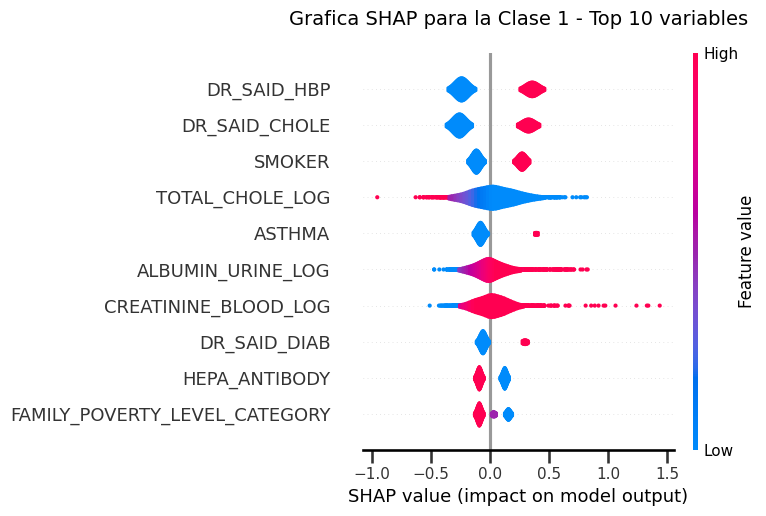

In [39]:
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split

background = X_train.sample(n=200, random_state=42)
explainer = shap.LinearExplainer(lda, background, feature_perturbation="interventional")

shap_values_test = explainer.shap_values(X_test)

feature_names = X_test.columns.tolist()
mean_abs_shap = np.mean(np.abs(shap_values_test), axis=0)

df_shap_importance = pd.DataFrame({
    "variable": feature_names,
    "mean_abs_shap": mean_abs_shap
})

df_shap_importance = df_shap_importance.sort_values(
    by="mean_abs_shap", ascending=False
).reset_index(drop=True)

print("Top 10 variables por SHAP (media absoluta) en todo el test set:")
print(df_shap_importance.head(10))

top10 = df_shap_importance["variable"].iloc[:10].tolist()
print("\nVariables seleccionadas para el SHAP Summary Plot:")
print(top10)

X_test_top10 = X_test[top10]

indices_top10 = [feature_names.index(f) for f in top10]
shap_values_top10 = shap_values_test[:, indices_top10]

plt.figure(figsize=(8, 6))
shap.summary_plot(
    shap_values_top10,
    X_test_top10,
    plot_type="violin",
    show=False
)
plt.title("Grafica SHAP para la Clase 1 - Top 10 variables", fontsize=14, pad=20)
plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/shap/explainers/_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


Top 10 variables por SHAP (media absoluta) hacia Clase 0:
                        variable  mean_abs_shap
0                    DR_SAID_HBP       0.287694
1                  DR_SAID_CHOLE       0.284614
2                         SMOKER       0.183282
3                TOTAL_CHOLE_LOG       0.160422
4                         ASTHMA       0.127841
5              ALBUMIN_URINE_LOG       0.117759
6           CREATININE_BLOOD_LOG       0.117008
7                   DR_SAID_DIAB       0.107984
8                  HEPA_ANTIBODY       0.107239
9  FAMILY_POVERTY_LEVEL_CATEGORY       0.102016

Variables seleccionadas para el SHAP Summary Plot (Clase 0):
['DR_SAID_HBP', 'DR_SAID_CHOLE', 'SMOKER', 'TOTAL_CHOLE_LOG', 'ASTHMA', 'ALBUMIN_URINE_LOG', 'CREATININE_BLOOD_LOG', 'DR_SAID_DIAB', 'HEPA_ANTIBODY', 'FAMILY_POVERTY_LEVEL_CATEGORY']


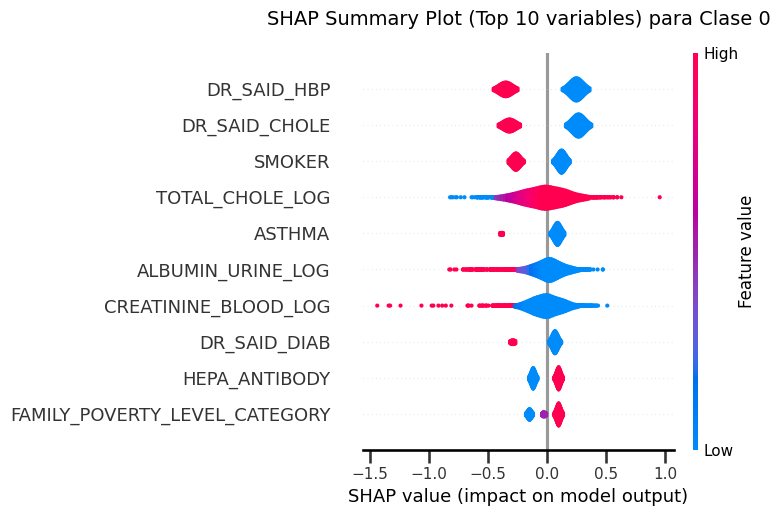

In [40]:
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split

background = X_train.sample(n=200, random_state=42)
explainer = shap.LinearExplainer(lda, background, feature_perturbation="interventional")

shap_values_test = explainer.shap_values(X_test)

shap_values_class0 = -shap_values_test

feature_names = X_test.columns.tolist()
mean_abs_shap_class0 = np.mean(np.abs(shap_values_class0), axis=0)

df_shap_imp0 = pd.DataFrame({
    "variable": feature_names,
    "mean_abs_shap": mean_abs_shap_class0
})
df_shap_imp0 = df_shap_imp0.sort_values(by="mean_abs_shap", ascending=False).reset_index(drop=True)

print("Top 10 variables por SHAP (media absoluta) hacia Clase 0:")
print(df_shap_imp0.head(10))

top10_class0 = df_shap_imp0["variable"].iloc[:10].tolist()
print("\nVariables seleccionadas para el SHAP Summary Plot (Clase 0):")
print(top10_class0)

X_test_top10_0 = X_test[top10_class0]
indices_top10_0 = [feature_names.index(v) for v in top10_class0]
shap_values_top10_class0 = shap_values_class0[:, indices_top10_0]

plt.figure(figsize=(8, 6))
shap.summary_plot(
    shap_values_top10_class0,
    X_test_top10_0,
    plot_type="violin",
    show=False
)
plt.title("SHAP Summary Plot (Top 10 variables) para Clase 0", fontsize=14, pad=20)
plt.tight_layout()
plt.show()


### TOTAL_CHOLE_LOG

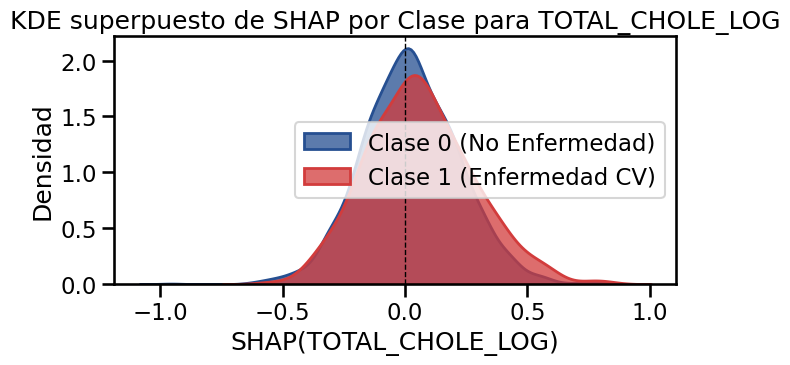

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

try:
    total_chole_log_index = X_test.columns.get_loc('TOTAL_CHOLE_LOG')
except KeyError:
    raise KeyError("La columna 'TOTAL_CHOLE_LOG' no se encontró en X_test. Revisa los nombres de las columnas.")

if isinstance(y_test, np.ndarray):
    y_true_series = pd.Series(y_test, index=X_test.index, name='y_true')
else:
    y_true_series = y_test.rename('y_true')

shap_array = (
    shap_values_test.values
    if hasattr(shap_values_test, 'values')
    else shap_values_test
)

df_chole = pd.DataFrame({
    'y_true':        y_true_series,
    'shap_TOTAL_CHOLE_LOG': shap_array[:, total_chole_log_index]
})

plt.figure(figsize=(7, 4))

sns.kdeplot(
    data=df_chole[df_chole['y_true'] == 0],
    x='shap_TOTAL_CHOLE_LOG',
    fill=True,
    alpha=0.75,
    linewidth=2,
    label='Clase 0 (No Enfermedad)',
    color='#264F91'
)


sns.kdeplot(
    data=df_chole[df_chole['y_true'] == 1],
    x='shap_TOTAL_CHOLE_LOG',
    fill=True,
    alpha=0.75,
    linewidth=2,
    label='Clase 1 (Enfermedad CV)',
    color='#D23C3C'
)

plt.axvline(0, color='k', linestyle='--', linewidth=1)

plt.xlabel('SHAP(TOTAL_CHOLE_LOG)')
plt.ylabel('Densidad')
plt.title('KDE superpuesto de SHAP por Clase para TOTAL_CHOLE_LOG')
plt.legend()

plt.tight_layout()
plt.show()


### ALBUMIN_URINE_LOG

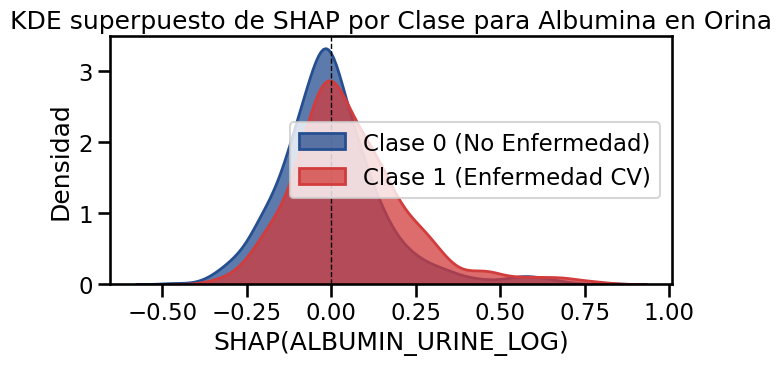

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

try:
    albumin_urine_log_index = X_test.columns.get_loc('ALBUMIN_URINE_LOG')
except KeyError:
    print("Error: 'ALBUMIN_URINE_LOG' not found in X_test columns. Please check variable names.")

if isinstance(y_test, np.ndarray):
    y_true_series = pd.Series(y_test, index=X_test.index, name='y_true')
else:
    y_true_series = y_test.rename('y_true')

shap_values_array = shap_values_test.values if hasattr(shap_values_test, 'values') else shap_values_test

df_chole = pd.DataFrame({
    "y_true": y_true_series,
    "shap_ALBUMIN_URINE_LOG": shap_values_array[:, albumin_urine_log_index] # Select the SHAP values for this variable
})

plt.figure(figsize=(7, 4))

sns.kdeplot(
    data=df_chole[df_chole["y_true"] == 0],
    x="shap_ALBUMIN_URINE_LOG",
    fill=True,
    alpha=0.75,
    linewidth=2,
    label="Clase 0 (No Enfermedad)",
    color="#264F91"
)

sns.kdeplot(
    data=df_chole[df_chole["y_true"] == 1],
    x="shap_ALBUMIN_URINE_LOG",
    fill=True,
    alpha=0.75,
    linewidth=2,
    label="Clase 1 (Enfermedad CV)",
    color="#D23C3C"
)


plt.axvline(0, color="k", linestyle="--", linewidth=1)


plt.xlabel("SHAP(ALBUMIN_URINE_LOG)")
plt.ylabel("Densidad")
plt.title("KDE superpuesto de SHAP por Clase para Albumina en Orina")
plt.legend()

plt.tight_layout()
plt.show()


### CREATININE_BLOOD_LOG

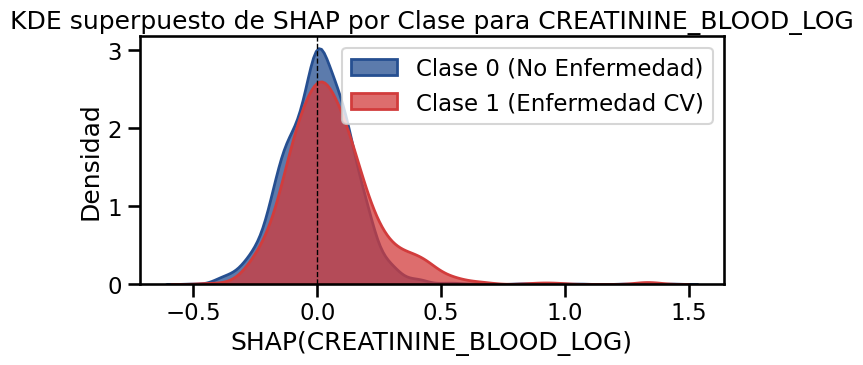

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

try:
    creatinine_index = X_test.columns.get_loc('CREATININE_BLOOD_LOG')
except KeyError:
    raise KeyError("La columna 'CREATININE_BLOOD_LOG' no se encontró en X_test. Revisa los nombres de las columnas.")

if isinstance(y_test, np.ndarray):
    y_true_series = pd.Series(y_test, index=X_test.index, name='y_true')
else:
    y_true_series = y_test.rename('y_true')

shap_array = (
    shap_values_test.values
    if hasattr(shap_values_test, 'values')
    else shap_values_test
)

df_creat = pd.DataFrame({
    'y_true': y_true_series,
    'shap_CREATININE_BLOOD_LOG': shap_array[:, creatinine_index]
})


plt.figure(figsize=(7, 4))


sns.kdeplot(
    data=df_creat[df_creat['y_true'] == 0],
    x='shap_CREATININE_BLOOD_LOG',
    fill=True,
    alpha=0.75,
    linewidth=2,
    label='Clase 0 (No Enfermedad)',
    color='#264F91'
)


sns.kdeplot(
    data=df_creat[df_creat['y_true'] == 1],
    x='shap_CREATININE_BLOOD_LOG',
    fill=True,
    alpha=0.75,
    linewidth=2,
    label='Clase 1 (Enfermedad CV)',
    color='#D23C3C'
)


plt.axvline(0, color='k', linestyle='--', linewidth=1)


plt.xlabel('SHAP(CREATININE_BLOOD_LOG)')
plt.ylabel('Densidad')
plt.title('KDE superpuesto de SHAP por Clase para CREATININE_BLOOD_LOG')
plt.legend()

plt.tight_layout()
plt.show()


### DR_SAID_CHOLE

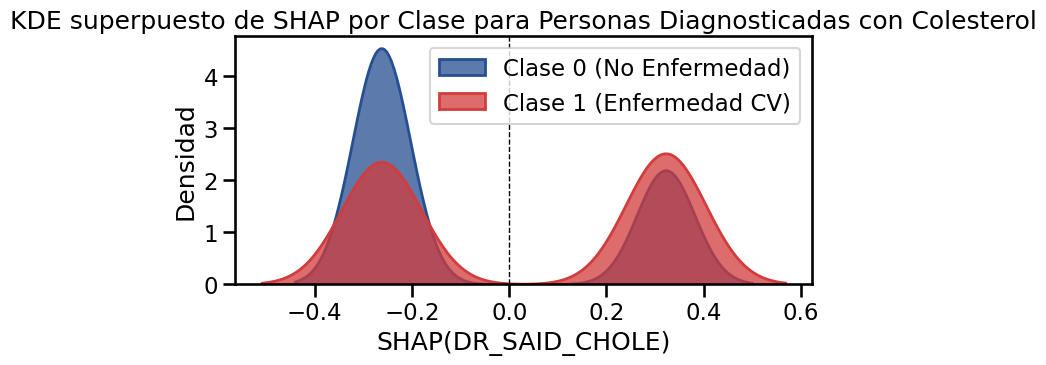

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

try:
    dr_said_chole_index = X_test.columns.get_loc('DR_SAID_CHOLE')
except KeyError:
    raise KeyError("La columna 'DR_SAID_CHOLE' no se encontró en X_test. Revisa los nombres de las columnas.")


if isinstance(y_test, np.ndarray):
    y_true_series = pd.Series(y_test, index=X_test.index, name='y_true')
else:
    y_true_series = y_test.rename('y_true')


shap_array = (
    shap_values_test.values
    if hasattr(shap_values_test, 'values')
    else shap_values_test
)


df_dr = pd.DataFrame({
    'y_true': y_true_series,
    'shap_DR_SAID_CHOLE': shap_array[:, dr_said_chole_index]
})


plt.figure(figsize=(7, 4))


sns.kdeplot(
    data=df_dr[df_dr['y_true'] == 0],
    x='shap_DR_SAID_CHOLE',
    fill=True,
    alpha=0.75,
    linewidth=2,
    label='Clase 0 (No Enfermedad)',
    color='#264F91'
)


sns.kdeplot(
    data=df_dr[df_dr['y_true'] == 1],
    x='shap_DR_SAID_CHOLE',
    fill=True,
    alpha=0.75,
    linewidth=2,
    label='Clase 1 (Enfermedad CV)',
    color='#D23C3C'
)


plt.axvline(0, color='k', linestyle='--', linewidth=1)


plt.xlabel('SHAP(DR_SAID_CHOLE)')
plt.ylabel('Densidad')
plt.title('KDE superpuesto de SHAP por Clase para Personas Diagnosticadas con Colesterol')
plt.legend()

plt.tight_layout()
plt.show()


### DR_SAID_HBP

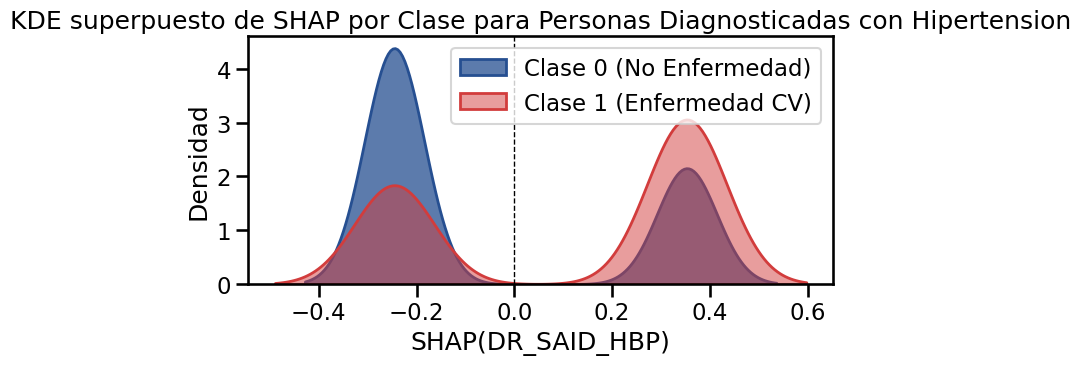

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

try:
    dr_said_hbp_index = X_test.columns.get_loc('DR_SAID_HBP')
except KeyError:
    raise KeyError("La columna 'DR_SAID_HBP' no se encontró en X_test. Revisa los nombres de las columnas.")

if isinstance(y_test, np.ndarray):
    y_true_series = pd.Series(y_test, index=X_test.index, name='y_true')
else:
    y_true_series = y_test.rename('y_true')


shap_array = (
    shap_values_test.values
    if hasattr(shap_values_test, 'values')
    else shap_values_test
)


df_hbp = pd.DataFrame({
    'y_true': y_true_series,
    'shap_DR_SAID_HBP': shap_array[:, dr_said_hbp_index]
})


plt.figure(figsize=(7, 4))


sns.kdeplot(
    data=df_hbp[df_hbp['y_true'] == 0],
    x='shap_DR_SAID_HBP',
    fill=True,
    alpha=0.75,
    linewidth=2,
    label='Clase 0 (No Enfermedad)',
    color='#264F91'
)


sns.kdeplot(
    data=df_hbp[df_hbp['y_true'] == 1],
    x='shap_DR_SAID_HBP',
    fill=True,
    alpha=0.5,
    linewidth=2,
    label='Clase 1 (Enfermedad CV)',
    color='#D23C3C'
)


plt.axvline(0, color='k', linestyle='--', linewidth=1)

plt.xlabel('SHAP(DR_SAID_HBP)')
plt.ylabel('Densidad')
plt.title('KDE superpuesto de SHAP por Clase para Personas Diagnosticadas con Hipertension')
plt.legend()

plt.tight_layout()
plt.show()


## EXPLICAR FALLOS EN LA CLASIFICACION

### Falsos Negativos Clase 1

In [46]:
import pandas as pd
import numpy as np

if isinstance(y_test, np.ndarray):
    y_true = pd.Series(y_test, index=X_test.index, name='y_true')
else:
    y_true = y_test.rename('y_true')

y_pred_series = pd.Series(y_pred_umbral, index=X_test.index, name='y_pred')

df_test = pd.concat([X_test, y_true, y_pred_series], axis=1)

df_false_negatives = df_test[(df_test['y_true'] == 1) & (df_test['y_pred'] == 0)]
print(f"Total de falsos negativos (clase 1 → 0): {len(df_false_negatives)}")
df_false_negatives

Total de falsos negativos (clase 1 → 0): 71


HEIGHT  WAIST_CIRCUMFERENCE_LOG  SYSTOLIC_MEAN_LOG  PULSE_MEAN_LOG  \
8743   0.791781                 0.580274           0.512012        0.443211   
23     0.424658                 0.495140           0.329534        0.546368   
11829  0.417808                 0.447849           0.255518        0.468615   
3787   0.668493                 0.445240           0.516466        0.565362   
7127   0.541096                 0.375378           0.430282        0.482745   
...         ...                      ...                ...             ...   
1161   0.569863                 0.243720           0.408011        0.486235   
4095   0.442466                 0.419597           0.345785        0.486235   
7620   0.412329                 0.290951           0.454398        0.468615   
5314   0.531507                 0.280445           0.402986        0.486235   
9502   0.291781                 0.548470           0.449626        0.533426   

       ALBUMIN_URINE_LOG  CREATININE_URINE_LOG   HDL_LOG  TOTAL_CHOLE_LOG  \
8743            0.195859              0.423546  0.487077         0.563742   
23              0.323697              0.671745  0.624373         0.353724   
11829           0.250184              0.629234  0.629188         0.360400   
3787            0.392282              0.817627  0.570637         0.493192   
7127            0.375347              0.731367  0.582300         0.436980   
...                  ...                   ...       ...              ...   
1161            0.239392              0.569152  0.749514         0.445416   
4095            0.216633              0.304473  0.604179         0.541334   
7620            0.281902              0.476026  0.688691         0.445416   
5314            0.208896              0.595099  0.593468         0.633078   
9502            0.303854              0.583748  0.564604         0.667943   

       LYMPHOCYTE_LOG  MONOCYTE_LOG  ...  ASTHMA  CANCER_OR_MALIGNANCY  \
8743         0.325985      0.261282  ...     0.0                   0.0   
23           0.361449      0.426133  ...     0.0                   0.0   
11829        0.285639      0.382772  ...     0.0                   0.0   
3787         0.259725      0.261282  ...     0.0                   0.0   
7127         0.268933      0.382772  ...     0.0                   0.0   
...               ...           ...  ...     ...                   ...   
1161         0.214815      0.329702  ...     0.0                   0.0   
4095         0.307331      0.382772  ...     1.0                   0.0   
7620         0.249833      0.261282  ...     0.0                   0.0   
5314         0.331666      0.329702  ...     0.0                   0.0   
9502         0.356924      0.426133  ...     0.0                   0.0   

       FEELING_DEPRESSED  SLEEPING_TOO_MUCH  WALK_OR_BICYCLE  \
8743            0.000000           0.000000              0.0   
23              0.000000           0.333333              0.0   
11829           0.000000           0.000000              0.0   
3787            0.000000           0.000000              0.0   
7127            0.000000           0.666667              0.0   
...                  ...                ...              ...   
1161            0.000000           1.000000              0.0   
4095            0.000000           0.333333              0.0   
7620            0.000000           0.000000              1.0   
5314            0.000000           0.000000              0.0   
9502            0.333333           0.000000              0.0   

       MINUTES_SEDENTARY_ACTIVITY  SMOKER  AGE_HEAVIEST_WEIGHT  y_true  y_pred  
8743                         0.60     1.0             0.449275       1       0  
23                           0.10     0.0             0.231884       1       0  
11829                        0.10     0.0             0.318841       1       0  
3787                         0.25     1.0             0.289855       1       0  
7127                         0.25     0.0             0.159420       1  

/usr/local/lib/python3.11/dist-packages/shap/explainers/_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


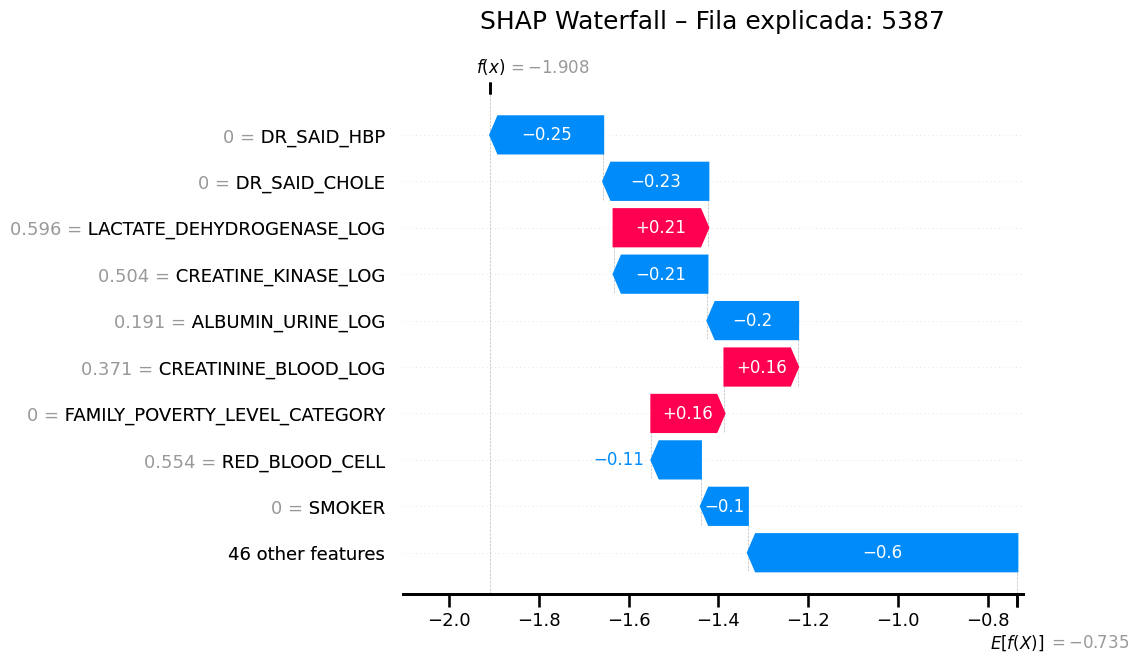

In [47]:
import random
import shap
import pandas as pd
import matplotlib.pyplot as plt

# 1) Índices de falsos negativos
false_negatives_indices = X_test.index[(y_test == 1) & (y_pred_umbral == 0)].tolist()
selected_index = random.choice(false_negatives_indices)

# 2) Subconjunto de fondo y explainer
background = shap.sample(X_train, 100, random_state=42)
explainer = shap.LinearExplainer(lda, background, feature_perturbation="interventional")

# 3) Calculamos SHAP para la instancia
instance_df = X_test.loc[[selected_index]]
shap_values = explainer.shap_values(instance_df)
exp = shap.Explanation(
    values=shap_values[0],
    base_values=explainer.expected_value,
    data=instance_df.iloc[0],
    feature_names=X_test.columns.tolist(),
)

# 4) Dibujamos el waterfall sin mostrarlo aún
shap.waterfall_plot(exp, show=False)

# 5) Recorremos las cajas y cambiamos color según el valor
ax = plt.gca()
for patch, val in zip(ax.patches, exp.values):
    # las barras negativas (val<0) moradas, positivas verdes
    patch.set_facecolor("#264F91" if val < 0 else "#F9C74F")

# 6) Título y mostrar
plt.title(f"SHAP Waterfall – Fila explicada: {selected_index}", pad=20)
plt.show()


In [48]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
top_idx = idx_desc[:10]

colors = [
    "#264F91" if idx == top_idx[0]
    else "#264F91" if idx == top_idx[1]
    else "#F9C74F"
    for idx in top_idx
][::-1]


labels = [
    "FAMILY_POVERTY_LEVEL" if feature_names[i] == "FAMILY_POVERTY_LEVEL_CATEGORY"
    else feature_names[i]
    for i in top_idx
][::-1]

plt.barh(
    labels,
    mean_abs_shap[top_idx][::-1],
    color=colors
)
plt.xlabel("Valor absoluto medio de SHAP")
plt.title("Importancia promedio en falsos negativos (clase 1→0)")
plt.tight_layout()
plt.show()


NameError: name 'idx_desc' is not defined

### Falsos Positivos Clase 0

In [ ]:
import pandas as pd
import numpy as np

if isinstance(y_test, np.ndarray):
    y_true = pd.Series(y_test, index=X_test.index, name='y_true')
else:
    y_true = y_test.rename('y_true')

y_pred_series = pd.Series(y_pred_umbral, index=X_test.index, name='y_pred')

df_test = pd.concat([X_test, y_true, y_pred_series], axis=1)

df_false_positives_class0 = df_test[(df_test['y_true'] == 0) & (df_test['y_pred'] == 1)]
print(f"Total de falsos positivos (clase 0 → 1): {len(df_false_positives_class0)}")
df_false_positives_class0


In [ ]:
import random
import shap
import pandas as pd
import matplotlib.pyplot as plt

false_positives_indices = X_test.index[(y_test == 0) & (y_pred_umbral == 1)].tolist()

if not false_positives_indices:
    print("No hay falsos positivos de la clase 0 en el conjunto de prueba.")
else:

    selected_index = random.choice(false_positives_indices)


    background = shap.sample(X_train, 100, random_state=42)


    explainer = shap.LinearExplainer(lda, background, feature_perturbation="interventional")


    instance_df = X_test.loc[[selected_index]]


    shap_values = explainer.shap_values(instance_df)

    shap.waterfall_plot(
        shap.Explanation(
            values=shap_values[0],
            base_values=explainer.expected_value,
            data=instance_df.iloc[0],
            feature_names=X_test.columns.tolist(),
        ),
        show=False
    )

    plt.title(f"SHAP Waterfall – Falsos positivos (clase 0→1), índice {selected_index}", pad=20)
    plt.show()


In [ ]:
if isinstance(y_test, np.ndarray):
    y_true = pd.Series(y_test, index=X_test.index, name='y_true')
else:
    y_true = y_test.rename('y_true')

y_pred_series = pd.Series(y_pred_umbral, index=X_test.index, name='y_pred')

df_test = pd.concat([X_test, y_true, y_pred_series], axis=1)

df_false_positives = df_test[(df_test['y_true'] == 0) & (df_test['y_pred'] == 1)]
print(f"Total de falsos positivos (Clase 0→1): {len(df_false_positives)}\n")

background = shap.sample(X_train, 100, random_state=42)
explainer = shap.LinearExplainer(lda, background, feature_perturbation="interventional")

sv = explainer.shap_values(X_test)
shap_values_test = sv[1] if isinstance(sv, list) else sv

false_positives_indices = df_false_positives.index.tolist()
false_positives_locs = [X_test.index.get_loc(i) for i in false_positives_indices]

shap_fp = shap_values_test[false_positives_locs, :]
mean_shap_fp     = np.mean(shap_fp, axis=0)
mean_abs_shap_fp = np.mean(np.abs(shap_fp), axis=0)

feature_names = X_test.columns.tolist()
idx_desc_fp = np.argsort(mean_abs_shap_fp)[::-1]




print("Top 10 features en falsos positivos (feature, SHAP medio, SHAP abs medio):")
for i in idx_desc_fp[:10]:
    feat = feature_names[i]
    print(f"{feat}: mean SHAP={mean_shap_fp[i]:.3f}, mean |SHAP|={mean_abs_shap_fp[i]:.3f}")
print()

plt.figure(figsize=(10, 8))
top_idx_fp = idx_desc_fp[:10]
plt.barh(
    [feature_names[i] for i in top_idx_fp][::-1],
    mean_abs_shap_fp[top_idx_fp][::-1],
    color = [ # Changed from colors to color
    "#264F91" if idx == top_idx[0]      # rojo para la variable más importante
    else "#264F91" if idx == top_idx[1] # azul para la segunda
    else "#F9C74F"                      # amarillo para las demás
    for idx in top_idx_fp # Use top_idx_fp here
][::-1]  # invertimos para que coincida con el orden de plt.barh
)


plt.xlabel("Valor absoluto medio de SHAP")
plt.title("Importancia promedio en falsos positivos (clase 0→1)")
plt.tight_layout()
plt.show()
